In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [1]:
!pip install torchaudio > .null.txt
!pip install PyDrive > .null.txt
!pip install soundfile > .null.txt

## Get the data

In [2]:
!git clone https://github.com/ogunlao/yoruba_speech_project.git ysp

Cloning into 'ysp'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 2394 (delta 13), reused 26 (delta 7), pack-reused 2361
Receiving objects: 100% (2394/2394), 288.13 MiB | 13.46 MiB/s, done.
Resolving deltas: 100% (1139/1139), done.
Checking out files: 100% (3012/3012), done.


## Get libraries and dependencies

In [3]:
!git clone https://github.com/facebookresearch/CPC_audio.git

Cloning into 'CPC_audio'...
remote: Enumerating objects: 84, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 84 (delta 13), reused 75 (delta 6), pack-reused 0
Unpacking objects: 100% (84/84), done.


In [4]:
%cd /content/CPC_audio
!python setup.py develop > .null.txt

/content/CPC_audio
In file included from /usr/local/lib/python3.6/dist-packages/numpy/core/include/numpy/ndarraytypes.h:1832:0,
                 from /usr/local/lib/python3.6/dist-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /usr/local/lib/python3.6/dist-packages/numpy/core/include/numpy/arrayobject.h:4,
                 from cpc/eval/ABX/dtw.c:625:
/usr/local/lib/python3.6/dist-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
 #warning "Using deprecated NumPy API, disable it with " \
  ^~~~~~~


## Getting data and language model

In [13]:
# !cp -R /content/gdrive/My\ Drive/speech_recognition/data.zip /content
# !unzip /content/data.zip -d /content/data > .null.txt

In [14]:
# !cp -R /content/gdrive/My\ Drive/speech_recognition/wiki_* /content

In [5]:
# get the code
!git clone --recursive https://github.com/parlance/ctcdecode.git
%cd ctcdecode

# install dependencies (PyTorch and CFFI)
!pip install -r requirements.txt

!python setup.py install > .null.txt
# If you do NOT require kenlm, the `--recursive` flag is not required on git clone
# and `--exclude-kenlm` should be appended to the `python setup.py install` command

Cloning into 'ctcdecode'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 979 (delta 3), reused 1 (delta 0), pack-reused 966
Receiving objects: 100% (979/979), 740.44 KiB | 834.00 KiB/s, done.
Resolving deltas: 100% (467/467), done.
Submodule 'third_party/ThreadPool' (https://github.com/progschj/ThreadPool.git) registered for path 'third_party/ThreadPool'
Submodule 'third_party/kenlm' (https://github.com/kpu/kenlm.git) registered for path 'third_party/kenlm'
Cloning into '/content/CPC_audio/ctcdecode/third_party/ThreadPool'...
remote: Enumerating objects: 82, done.        
remote: Total 82 (delta 0), reused 0 (delta 0), pack-reused 82        
Cloning into '/content/CPC_audio/ctcdecode/third_party/kenlm'...
remote: Enumerating objects: 97, done.        
remote: Counting objects: 100% (97/97), done.        
remote: Compressing objects: 100% (80/80), done.        
remote: Total 13421 (del

Warning: Restart runtime after the above installations and run the remaining steps below without installing again.

In [29]:
import torch
import torchaudio
from ctcdecode import CTCBeamDecoder
from torch.optim.lr_scheduler import ReduceLROnPlateau


# Part 1 : contrastive predictive coding

Contrastive Predictive Coding (CPC) is a method of unsupervised training for speech models. The idea behind it is pretty simple:


1.   The raw audio wave is passed through a convolutional network: the ```encoder```
2.   Then, the encoder's output is given to a recurrent network the ```context```
3. A third party network, the ```prediction_network``` will try to predict the  future embeddings of the encoder using the output of the context network.

In order to avoid a collapse to trivial solutions, the prediction_network doesn't try to reconstruct the future features. Instead, using the context output $c_t$ at time $t$ it is trained to discriminate the real  encoder representatioin $g_{t+k}$ at time $t+k$ from several other features $(g_n)_n$ taken elsewhere in the batch. Thus the loss becomes:

\\[ \mathcal{L}_c = - \frac{1}{K} \sum_{k=1}^K \text{Cross_entropy}(\phi_k(c_t), g_{t+k}) \\]

Or:

\\[ \mathcal{L}_c = - \frac{1}{K} \sum_{k=1}^K \log \frac{ \exp\left(\phi_k(c_t)^\top g_{t+k}\right) }{  \sum_{\mathbf{n}\in\mathcal{N}_t} \exp\left(\phi_k(c_t)^\top g_n\right)} \\]

Where:


*   $\phi_k$ is the prediction network for the kth timestep
*   $\mathcal{N}_t$ is the set of all negative examples sampled for timestep $t$




## Exercice 1 : Building the model

In this exercise, we will build and train a small CPC model using the repository CPC_audio.

The code below loads a context and an encoder newtorks.

In [30]:
%cd /content/CPC_audio
from cpc.model import CPCEncoder, CPCAR
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

DIM_ENCODER=256
DIM_CONTEXT=256
KEEP_HIDDEN_VECTOR=False
N_LEVELS_CONTEXT=1
CONTEXT_RNN="LSTM"
N_PREDICTIONS=12
LEARNING_RATE=2e-4
N_NEGATIVE_SAMPLE =128

/content/CPC_audio


In [31]:
encoder = CPCEncoder(DIM_ENCODER).to(device)
context = CPCAR(DIM_ENCODER, DIM_CONTEXT, KEEP_HIDDEN_VECTOR, 1, mode=CONTEXT_RNN).to(device)

In [32]:
# Several functions that will be necessary to load the data later
from cpc.dataset import findAllSeqs, AudioBatchData, parseSeqLabels
SIZE_WINDOW = 20480
BATCH_SIZE=8
def load_dataset(path_dataset, file_extension='.wav', phone_label_dict=None):
  data_list, speakers = findAllSeqs(path_dataset, extension=file_extension)
  dataset = AudioBatchData(path_dataset, SIZE_WINDOW, data_list, phone_label_dict, len(speakers))
  return dataset

Now build a new class, ```CPCModel``` which will

In [33]:
class CPCModel(torch.nn.Module):

    def __init__(self,
                 encoder,
                 AR):

        super(CPCModel, self).__init__()
        self.gEncoder = encoder
        self.gAR = AR

    def forward(self, batch_data):

        encoder_output = self.gEncoder(batch_data)
        

        #print(encoder_output.shape)
        # The output of the encoder data does not have the good format 
        # indeed it is Batch_size x Hidden_size x temp size
        # while the context requires Batch_size  x temp size x Hidden_size
        # thus you need to permute
        context_input = encoder_output.permute(0, 2, 1)
        

        context_output = self.gAR(context_input)
        
        #print(context_output.shape)
        return context_output, encoder_output

Let's test your code !


In [34]:
DATA_PATH = "/content/ysp/data/"
audio = torchaudio.load("/content/ysp/data/records/train/200625-215447_yor_874_elicit_13.wav")[0]
audio = audio.view(1, 1, -1)
cpc_model = CPCModel(encoder, context).to(device)
context_output, encoder_output = cpc_model(audio.to(device))

# Part 2 : Fine tuning

In [35]:
!mkdir checkpoint_data
!wget https://dl.fbaipublicfiles.com/librilight/CPC_checkpoints/not_hub/2levels_6k_top_ctc/checkpoint_30.pt -P checkpoint_data > .null.txt
!wget https://dl.fbaipublicfiles.com/librilight/CPC_checkpoints/not_hub/2levels_6k_top_ctc/checkpoint_logs.json -P checkpoint_data > .null.txt
!wget https://dl.fbaipublicfiles.com/librilight/CPC_checkpoints/not_hub/2levels_6k_top_ctc/checkpoint_args.json -P checkpoint_data > .null.txt
!ls checkpoint_data

mkdir: cannot create directory ‘checkpoint_data’: File exists
--2020-07-06 20:01:07--  https://dl.fbaipublicfiles.com/librilight/CPC_checkpoints/not_hub/2levels_6k_top_ctc/checkpoint_30.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 104.22.75.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 113599715 (108M) [application/octet-stream]
Saving to: ‘checkpoint_data/checkpoint_30.pt.1’

checkpoint_30.pt.1  100%[===================>] 108.34M  12.3MB/s    in 10s     

2020-07-06 20:01:18 (10.8 MB/s) - ‘checkpoint_data/checkpoint_30.pt.1’ saved [113599715/113599715]

--2020-07-06 20:01:19--  https://dl.fbaipublicfiles.com/librilight/CPC_checkpoints/not_hub/2levels_6k_top_ctc/checkpoint_logs.json
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 104.22.75.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.f

Then we will use a simple linear classifier to recognize the phonemes from the features produced by ```cpc_model```. 

### a) Build the character classifier 

Design a class of linear classifiers, ```CharacterClassifier``` that will take as input a batch of sequences of CPC features and output a score vector for each phoneme

In [36]:
class CharacterClassifier(torch.nn.Module):

  def __init__(self,
               input_dim : int,
               n_characters : int):
    super(CharacterClassifier, self).__init__()
    self.linear = torch.nn.Linear(input_dim, n_characters)
    

  def forward(self, x):
    return self.linear(x)

Our phone classifier will then be:

## Exercise 2 : Characters separability without alignment (CER)

Aligned data are very practical, but un real life they are rarely available. That's why in this excercise we will consider a fine-tuning with non-aligned phonemes.

The model, the optimizer and the phone classifier will stay the same. However, we will replace our phone criterion with a [CTC loss](https://pytorch.org/docs/master/generated/torch.nn.CTCLoss.html). 

In [9]:
loss_ctc = torch.nn.CTCLoss()

Besides, we will use a siglthy different dataset class.

### a- Training

Since the phonemes are not aligned, there is no simple direct way to get the classification acuracy of a model. Write and test the three functions ```train_one_epoch_ctc```, ```validation_step_ctc``` and ```run_ctc``` as before but without considering the average acuracy of the model. 

In [37]:
import torch.nn.functional as F

def train_one_epoch_ctc(cpc_model, 
                        character_classifier, 
                        loss_criterion, 
                        data_loader, 
                        optimizer):
  
  cpc_model.train()
  loss_criterion.train()

  avg_loss = 0
  avg_accuracy = 0
  n_items = 0
  for step, full_data in enumerate(data_loader):

    x, x_len, y, y_len = full_data

    x_batch_len = x.shape[-1]
    x, y = x.to(device), y.to(device)

    bs=x.size(0)
    optimizer.zero_grad()
    context_out, enc_out, _ = cpc_model(x.to(device),y.to(device))
  
    scores = character_classifier(context_out)
    scores = scores.permute(1,0,2)
    scores = F.log_softmax(scores,2)
    yhat_len = torch.tensor([int(scores.shape[0]*x_len[i]/(x_batch_len)) for i in range(scores.shape[1])]) # this is an approximation, should be good enough
    #print(yhat_len)
    loss = loss_criterion(scores,y.to(device),yhat_len,y_len)
    loss.backward()
    optimizer.step()
    avg_loss+=loss.item()*bs
    n_items+=bs
  avg_loss/=n_items
  return avg_loss

def validation_step(cpc_model, 
                    character_classifier, 
                    loss_criterion, 
                    data_loader):

  cpc_model.eval()
  character_classifier.eval()
  avg_loss = 0
  avg_accuracy = 0
  n_items = 0
  with torch.no_grad():
    for step, full_data in enumerate(data_loader):

      x, x_len, y, y_len = full_data

      x_batch_len = x.shape[-1]
      x, y = x.to(device), y.to(device)

      bs=x.size(0)
      context_out, enc_out, _ = cpc_model(x.to(device),y.to(device))
    
      scores = character_classifier(context_out)
      scores = scores.permute(1,0,2)
      scores = F.log_softmax(scores,2)
      yhat_len = torch.tensor([int(scores.shape[0]*x_len[i]/x_batch_len) for i in range(scores.shape[1])]) # this is an approximation, should be good enough
      loss = loss_criterion(scores,y.to(device),yhat_len,y_len)
      avg_loss+=loss.item()*bs
      n_items+=bs
  avg_loss/=n_items

  return avg_loss

def run_ctc(cpc_model, 
            character_classifier, 
            loss_criterion, 
            data_loader_train, 
            data_loader_val, 
            optimizer,
            lr_sch,
            n_epoch):
  losses_train = []
  losses_val = []
  per_val = []
  best_cer = float("inf")
  for epoch in range(n_epoch):

    print(f"Running epoch {epoch + 1} / {n_epoch}")
    loss_train = train_one_epoch_ctc(cpc_model, character_classifier, loss_criterion, data_loader_train, optimizer)
    losses_train.append(loss_train)
    print("-------------------")
    print(f"Training dataset :")
    print(f"Average loss : {loss_train}.")

    print("-------------------")
    print("Validation dataset")
    loss_val = validation_step(cpc_model, character_classifier, loss_criterion, data_loader_val)
    losses_val.append(loss_val)
    lr_sch.step(loss_val)
    cer = get_cer(data_loader_val_letters,cpc_model,character_classifier)
    per_val.append(cer)

    if cer<best_cer:
      best_cer=cer
      save_checkpoint(cpc_model,character_classifier)

    print(f"Average loss : {loss_val}")
    print("-------------------")
    print()
    if optimizer.param_groups[0]['lr']<1e-7:
      print("Learning rate reached critical point, Aborting")
      break
  print("loading best model with CER ",best_cer)
  load_checkpoint(cpc_model,character_classifier)
  return losses_train,losses_val, per_val

def save_checkpoint(model,classifier,path="/content/checkpoint.ckpt"):
  torch.save(model.state_dict(), path)
  torch.save(classifier.state_dict(), path+".classifier")


def load_checkpoint(model,classifier,path="/content/checkpoint.ckpt"):
  model.load_state_dict(torch.load(path))
  classifier.load_state_dict(torch.load(path+".classifier"))

### b- Evaluation: the Character Error Rate (CER)

In order to compute the similarity between two sequences, we can use the [Levenshtein distance](https://en.wikipedia.org/wiki/Levenshtein_distance). This distance estimates the minimum number of insertion, deletion and addition to move from one sequence to another. If we normalize this distance by the number of characters in the reference sequence we get the Character Error Rate (CER).

This value can be interpreted as :
\\[  CER = \frac{S + D + I}{N} \\]

Where:


*   N is the number of characters in the reference
*   S is the number of substitutiion
*   I in the number of insertion
*   D in the number of deletion

For the best possible alignment of the two sequences.



In [38]:
import numpy as np

def get_CER_sequence(ref_seq, target_seq):

  # re = g.split()
  # h = h.split()
  n = len(ref_seq)
  m = len(target_seq)

  D = np.zeros((n+1, m+1))
  for i in range(1, n+1):
    D[i,0] = D[i-1, 0]+1
  for j in range(1, m+1):
    D[0,j] = D[0, j-1]+1
  
  ### TODO compute the alignment

  for i in range(1, n+1):
    for j in range(1, m+1):
      D[i,j] = min(
          D[i-1, j]+1,
          D[i-1, j-1]+1,
          D[i, j-1]+1,
          D[i-1, j-1]+ 0 if ref_seq[i-1]==target_seq[j-1] else float("inf")
      )
  return D[n,m]/len(ref_seq)
  

You can test your function below:

In [39]:
ref_seq = [0, 1, 1, 2, 0, 2, 2]
pred_seq = [1, 1, 2, 2, 0, 0]

expected_CER = 4. / 7.
print(get_CER_sequence(ref_seq, pred_seq) == expected_CER)

True


### c- Evaluating the PER of your model on the test dataset

Evaluate the PER on the validation dataset. Please notice that you should usually use a separate dataset, called the dev dataset, to perform this operation. However for the sake of simplicity we will work with validation data in this exercise.

In [52]:
import progressbar
from multiprocessing import Pool

def cut_data(seq, sizeSeq):
    maxSeq = sizeSeq.max()
    return seq[:, :maxSeq]


def prepare_data(data):
    seq, sizeSeq, phone, sizePhone = data
    seq = seq.cuda()
    phone = phone.cuda()
    sizeSeq = sizeSeq.cuda().view(-1)
    sizePhone = sizePhone.cuda().view(-1)

    seq = cut_data(seq.permute(0, 2, 1), sizeSeq).permute(0, 2, 1)
    return seq, sizeSeq, phone, sizePhone


def get_cer(test_dataloader,
            cpc_model,
            character_classifier):

  downsampling_factor = 1
  cpc_model.eval()
  character_classifier.eval()

  avgCER = 0
  nItems = 0

  print("Starting the CER computation through beam search")
  bar = progressbar.ProgressBar(maxval=len(test_dataloader))
  bar.start()

  for index, data in enumerate(test_dataloader):

    bar.update(index)
    with torch.no_grad():
        seq, sizeSeq, phone, sizePhone = prepare_data(data)
        x_batch_len = seq.shape[-1]
        c_feature, _, _ = cpc_model(seq.to(device),phone.to(device))
        bs = c_feature.size(0)
        sizeSeq = sizeSeq / downsampling_factor
        predictions = torch.nn.functional.softmax(
            character_classifier(c_feature), dim=2
            ).cpu()
        phone = phone.cpu()
        sizeSeq = sizeSeq.cpu()
        sizePhone = sizePhone.cpu()
        # print("predictions",predictions.argmax(2)[0])
        # print(phone[0])
        
        seq_len = torch.tensor([int(predictions.shape[1]*sizeSeq[i]/(x_batch_len)) for i in range(predictions.shape[0])]) # this is an approximation, should be good enough
        #print(seq_len)
        decoder = CTCBeamDecoder(chars, log_probs_input=False,blank_id=0,beam_width=20,cutoff_top_n=20, model_path="/content/ysp/language_model/yor_5gram.lm.arpa")
        output, scores, timesteps, out_seq_len = decoder.decode(predictions, seq_lens=seq_len)
        
        output=output[torch.arange(bs),scores.argmax(1),:]
        out_seq_len= out_seq_len[torch.arange(bs),scores.argmax(1)]
        data_cer = []
        for b in range(bs):
          # print(sizePhone[b], out_seq_len[b])
          data_cer.append((phone[b][:sizePhone[b].item()],output[b][:out_seq_len[b].item()]))
          
        #data_cer = [(predictions[b].argmax(1),  phone[b]) for b in range(bs)]
        # data_cer = [(predictions[b], sizeSeq[b], phone[b], sizePhone[b],
        #               "criterion.module.BLANK_LABEL") for b in range(bs)]
        with Pool(bs) as p:
            poolData = p.starmap(get_CER_sequence, data_cer)
        avgCER += sum([x for x in poolData])
        nItems += len(poolData)

  bar.finish()

  avgCER /= nItems

  print(f"Average CER {avgCER}")
  return avgCER


In [53]:
with open("/content/ysp/data/charset.txt") as js:
  characters = eval(js.read())

In [54]:
chars = [0]*len(characters)
for k,v in characters.items():
  chars[v]=k

chars[1] = '$' # Add space char to model

print(chars)

['ε', '$', 's', 'g', 'p', 'ò', 'v', 'é', 'k', 'e', 'ọ', 'ṣ', 'd', 'è', 'i', 'í', 'ẹ', 'ú', 'ù', 'r', 'l', 'j', 'ì', 'á', 'y', 't', 'n', 'a', 'à', 'b', 'o', 'h', 'w', 'ó', 'f', 'u', 'm', 'c', '–', 'ń', 'ǹ', 'z', 'ḿ', 'ί', 'ὸ']


In [55]:
len(chars)

45

In [56]:
# Load a dataset labelled with the letters of each sequence.
%cd /content/CPC_audio
from cpc.eval.common_voices_eval import SingleSequenceDataset, parseSeqLabels, findAllSeqs
path_train_data_cer = '/content/ysp/data/records/train/'
path_val_data_cer = '/content/ysp/data/records/val'
path_letter_data_cer = '/content/ysp/data/chars.txt'
BATCH_SIZE=2

letters_labels, N_LETTERS = parseSeqLabels(path_letter_data_cer)
N_LETTERS=len(chars) # for the blank token
data_train_cer, _ = findAllSeqs(path_train_data_cer, extension='.wav')
dataset_train_non_aligned = SingleSequenceDataset(path_train_data_cer, data_train_cer, letters_labels)


data_val_cer, _ = findAllSeqs(path_val_data_cer, extension='.wav')
dataset_val_non_aligned = SingleSequenceDataset(path_val_data_cer, data_val_cer, letters_labels)
path_letter_data_cer

# The data loader will generate a tuple of tensors data, labels for each batch
# data : size N x T1 x 1 : the audio sequence
# label : size N x T2 the sequence of letters corresponding to the audio data
# IMPORTANT NOTE: just like the PER the CER is computed with non-aligned phone data.
torch.manual_seed(0)
data_loader_train_letters = torch.utils.data.DataLoader(dataset_train_non_aligned, batch_size=BATCH_SIZE,
                                                shuffle=True)
data_loader_val_letters = torch.utils.data.DataLoader(dataset_val_non_aligned, batch_size=BATCH_SIZE,
                                              shuffle=False)

1it [00:00, 242.08it/s]

/content/CPC_audio
Saved cache file at /content/ysp/data/records/train/_seqs_cache.txt



1it [00:00, 154.19it/s]

Loaded 281 sequences in 2.17 seconds
maxSizeSeq : 321981
maxSizePhone : 118
minSizePhone : 2
Total size dataset 0.8402519965277778 hours
Saved cache file at /content/ysp/data/records/val/_seqs_cache.txt


Loaded 71 sequences in 1.58 seconds
maxSizeSeq : 291852
maxSizePhone : 103
minSizePhone : 5
Total size dataset 0.19658164930555555 hours


In [57]:
path_test_data_cer = '/content/ysp/data/records/test/'
data_test_cer, _ = findAllSeqs(path_test_data_cer, extension='.wav')
dataset_test_non_aligned = SingleSequenceDataset(path_test_data_cer, data_test_cer, letters_labels)
data_loader_test_letters = torch.utils.data.DataLoader(dataset_test_non_aligned, batch_size=BATCH_SIZE,
                                              shuffle=False)

1it [00:00, 482.71it/s]

Saved cache file at /content/ysp/data/records/test/_seqs_cache.txt


Loaded 351 sequences in 2.45 seconds
maxSizeSeq : 450120
maxSizePhone : 128
minSizePhone : 2
Total size dataset 1.0097087152777777 hours


In [58]:
from cpc.feature_loader import loadModel
torch.manual_seed(0)

checkpoint_path = 'checkpoint_data/checkpoint_30.pt'
cpc_model, HIDDEN_CONTEXT_MODEL, HIDDEN_ENCODER_MODEL = loadModel([checkpoint_path])
cpc_model = cpc_model.cuda()
character_classifier = CharacterClassifier(HIDDEN_CONTEXT_MODEL, N_LETTERS).to(device)

Loading checkpoint checkpoint_data/checkpoint_30.pt
Loading the state dict at checkpoint_data/checkpoint_30.pt


In [59]:
parameters = list(character_classifier.parameters()) + list(cpc_model.parameters())
LEARNING_RATE = 2e-4
optimizer = torch.optim.Adam(parameters, lr=LEARNING_RATE)
lr_sch = ReduceLROnPlateau(optimizer,factor=0.2,patience=5,verbose=True)

optimizer_frozen = torch.optim.Adam(list(character_classifier.parameters()), lr=LEARNING_RATE)
lr_sch_frozen = ReduceLROnPlateau(optimizer_frozen,factor=0.2,patience=5,verbose=True)


In [60]:
loss_ctc = torch.nn.CTCLoss()

In [61]:
torch.manual_seed(0)
losses_train, losses_val, cer_val = run_ctc(
    cpc_model,
    character_classifier,
    loss_ctc,
    data_loader_train_letters,
    data_loader_val_letters,
    optimizer, lr_sch,n_epoch=80)

Running epoch 1 / 80
-------------------
Training dataset :
Average loss : 22.58541041612625.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


Average CER 0.9833745350639711
Average loss : 3.713878754207066
-------------------

Running epoch 2 / 80
-------------------
Training dataset :
Average loss : 3.5176642877714976.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


Average CER 0.9919259960429049
Average loss : 3.365426417759487
-------------------

Running epoch 3 / 80
-------------------
Training dataset :
Average loss : 3.3582411902291436.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


Average CER 0.9874342927464186
Average loss : 3.282261392048427
-------------------

Running epoch 4 / 80
-------------------
Training dataset :
Average loss : 3.2882194672312055.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


Average CER 0.991392347008784
Average loss : 3.2425023555755614
-------------------

Running epoch 5 / 80
-------------------
Training dataset :
Average loss : 3.260121514116015.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


Average CER 0.9907964851343565
Average loss : 3.2282787936074393
-------------------

Running epoch 6 / 80
-------------------
Training dataset :
Average loss : 3.2405669263431003.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


Average CER 0.9907964851343565
Average loss : 3.2245838369641984
-------------------

Running epoch 7 / 80
-------------------
Training dataset :
Average loss : 3.227260637283325.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


Average CER 0.9870771498892759
Average loss : 3.217293984549386
-------------------

Running epoch 8 / 80
-------------------
Training dataset :
Average loss : 3.227239624091557.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


Average CER 0.9907964851343565
Average loss : 3.21597729410444
-------------------

Running epoch 9 / 80
-------------------
Training dataset :
Average loss : 3.2162922671863012.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


Average CER 0.9870771498892759
Average loss : 3.2098982538495746
-------------------

Running epoch 10 / 80
-------------------
Training dataset :
Average loss : 3.212034387247903.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


Average CER 0.9899792726483704
Average loss : 3.210411548614502
-------------------

Running epoch 11 / 80
-------------------
Training dataset :
Average loss : 3.215449174812862.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


Average CER 0.989757705781842
Average loss : 3.207201848711286
-------------------

Running epoch 12 / 80
-------------------
Training dataset :
Average loss : 3.208164002214159.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


Average CER 0.9772329544223906
Average loss : 3.2104804856436595
-------------------

Running epoch 13 / 80
-------------------
Training dataset :
Average loss : 3.2040261370795116.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


Average CER 0.9909598343073807
Average loss : 3.20286853654044
-------------------

Running epoch 14 / 80
-------------------
Training dataset :
Average loss : 3.1999507869992936.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


Average CER 0.9909598343073807
Average loss : 3.2001973492758613
-------------------

Running epoch 15 / 80
-------------------
Training dataset :
Average loss : 3.200479905945914.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


Average CER 0.9855412454228887
Average loss : 3.204040677206857
-------------------

Running epoch 16 / 80
-------------------
Training dataset :
Average loss : 3.193856738294874.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


Average CER 0.9852665201481634
Average loss : 3.2014036451067245
-------------------

Running epoch 17 / 80
-------------------
Training dataset :
Average loss : 3.191662723677499.
-------------------
Validation dataset
Running epoch 1 / 80
-------------------
Training dataset :
Average loss : 22.58541041612625.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


Average CER 0.9833745350639711
Average loss : 3.713878754207066
-------------------

Running epoch 2 / 80
-------------------
Training dataset :
Average loss : 3.5176642877714976.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


Average CER 0.9919259960429049
Average loss : 3.365426417759487
-------------------

Running epoch 3 / 80
-------------------
Training dataset :
Average loss : 3.3582411902291436.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


Average CER 0.9874342927464186
Average loss : 3.282261392048427
-------------------

Running epoch 4 / 80
-------------------
Training dataset :
Average loss : 3.2882194672312055.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


Average CER 0.991392347008784
Average loss : 3.2425023555755614
-------------------

Running epoch 5 / 80
-------------------
Training dataset :
Average loss : 3.260121514116015.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


Average CER 0.9907964851343565
Average loss : 3.2282787936074393
-------------------

Running epoch 6 / 80
-------------------
Training dataset :
Average loss : 3.2405669263431003.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


Average CER 0.9907964851343565
Average loss : 3.2245838369641984
-------------------

Running epoch 7 / 80
-------------------
Training dataset :
Average loss : 3.227260637283325.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


Average CER 0.9870771498892759
Average loss : 3.217293984549386
-------------------

Running epoch 8 / 80
-------------------
Training dataset :
Average loss : 3.227239624091557.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


Average CER 0.9907964851343565
Average loss : 3.21597729410444
-------------------

Running epoch 9 / 80
-------------------
Training dataset :
Average loss : 3.2162922671863012.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


Average CER 0.9870771498892759
Average loss : 3.2098982538495746
-------------------

Running epoch 10 / 80
-------------------
Training dataset :
Average loss : 3.212034387247903.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


Average CER 0.9899792726483704
Average loss : 3.210411548614502
-------------------

Running epoch 11 / 80
-------------------
Training dataset :
Average loss : 3.215449174812862.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


Average CER 0.989757705781842
Average loss : 3.207201848711286
-------------------

Running epoch 12 / 80
-------------------
Training dataset :
Average loss : 3.208164002214159.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


Average CER 0.9772329544223906
Average loss : 3.2104804856436595
-------------------

Running epoch 13 / 80
-------------------
Training dataset :
Average loss : 3.2040261370795116.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


Average CER 0.9909598343073807
Average loss : 3.20286853654044
-------------------

Running epoch 14 / 80
-------------------
Training dataset :
Average loss : 3.1999507869992936.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


Average CER 0.9909598343073807
Average loss : 3.2001973492758613
-------------------

Running epoch 15 / 80
-------------------
Training dataset :
Average loss : 3.200479905945914.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


Average CER 0.9855412454228887
Average loss : 3.204040677206857
-------------------

Running epoch 16 / 80
-------------------
Training dataset :
Average loss : 3.193856738294874.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


Average CER 0.9852665201481634
Average loss : 3.2014036451067245
-------------------

Running epoch 17 / 80
-------------------
Training dataset :
Average loss : 3.191662723677499.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search
Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14



Average CER 0.9903120199767236
Average loss : 3.195803042820522
-------------------

Running epoch 18 / 80
Average CER 0.9903120199767236
Average loss : 3.195803042820522
-------------------

Running epoch 18 / 80
-------------------
Training dataset :
Average loss : 3.1865727509771076.
-------------------
Validation dataset
-------------------
Training dataset :
Average loss : 3.1865727509771076.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search
Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14



Average CER 0.990586745251449
Average loss : 3.1906682763780867
-------------------

Running epoch 19 / 80
Average CER 0.990586745251449
Average loss : 3.1906682763780867
-------------------

Running epoch 19 / 80
-------------------
Training dataset :
Average loss : 3.1756353190967013.
-------------------
Validation dataset
-------------------
Training dataset :
Average loss : 3.1756353190967013.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search
Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14



Average CER 0.9903120199767236
Average loss : 3.1848832471030097
-------------------

Running epoch 20 / 80
Average CER 0.9903120199767236
Average loss : 3.1848832471030097
-------------------

Running epoch 20 / 80
-------------------
Training dataset :
Average loss : 3.1643096804618835.
-------------------
Validation dataset
-------------------
Training dataset :
Average loss : 3.1643096804618835.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search
Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14



Average CER 0.9903120199767236
Average loss : 3.1643957001822334
-------------------

Running epoch 21 / 80
Average CER 0.9903120199767236
Average loss : 3.1643957001822334
-------------------

Running epoch 21 / 80
-------------------
Training dataset :
Average loss : 3.1349937915802.
-------------------
Validation dataset
-------------------
Training dataset :
Average loss : 3.1349937915802.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search
Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14



Average CER 0.990586745251449
Average loss : 3.131744166782924
-------------------

Running epoch 22 / 80
Average CER 0.990586745251449
Average loss : 3.131744166782924
-------------------

Running epoch 22 / 80
-------------------
Training dataset :
Average loss : 3.1189506479672024.
-------------------
Validation dataset
-------------------
Training dataset :
Average loss : 3.1189506479672024.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search
Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14



Average CER 0.9903120199767236
Average loss : 3.1047531196049283
-------------------

Running epoch 23 / 80
Average CER 0.9903120199767236
Average loss : 3.1047531196049283
-------------------

Running epoch 23 / 80
-------------------
Training dataset :
Average loss : 3.049508282116481.
-------------------
Validation dataset
-------------------
Training dataset :
Average loss : 3.049508282116481.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search
Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14



Average CER 0.990586745251449
Average loss : 3.0142736775534495
-------------------

Running epoch 24 / 80
Average CER 0.990586745251449
Average loss : 3.0142736775534495
-------------------

Running epoch 24 / 80
-------------------
Training dataset :
Average loss : 2.9540454506874085.
-------------------
Validation dataset
-------------------
Training dataset :
Average loss : 2.9540454506874085.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search
Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14



Average CER 0.9889647362474779
Average loss : 2.9022286142621723
-------------------

Running epoch 25 / 80
Average CER 0.9889647362474779
Average loss : 2.9022286142621723
-------------------

Running epoch 25 / 80
-------------------
Training dataset :
Average loss : 2.836155825001853.
-------------------
Validation dataset
-------------------
Training dataset :
Average loss : 2.836155825001853.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search
Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14



Average CER 0.9744270566262744
Average loss : 2.783018010003226
-------------------

Running epoch 26 / 80
Average CER 0.9744270566262744
Average loss : 2.783018010003226
-------------------

Running epoch 26 / 80
-------------------
Training dataset :
Average loss : 2.7094411901065283.
-------------------
Validation dataset
-------------------
Training dataset :
Average loss : 2.7094411901065283.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search
Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14



Average CER 0.9009461890108157
Average loss : 2.6541287354060583
-------------------

Running epoch 27 / 80
Average CER 0.9009461890108157
Average loss : 2.6541287354060583
-------------------

Running epoch 27 / 80
-------------------
Training dataset :
Average loss : 2.572182905673981.
-------------------
Validation dataset
-------------------
Training dataset :
Average loss : 2.572182905673981.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search
Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14



Average CER 0.8191658115772135
Average loss : 2.488010467801775
-------------------

Running epoch 28 / 80
Average CER 0.8191658115772135
Average loss : 2.488010467801775
-------------------

Running epoch 28 / 80
-------------------
Training dataset :
Average loss : 2.3967937673841204.
-------------------
Validation dataset
-------------------
Training dataset :
Average loss : 2.3967937673841204.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search
Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14



Average CER 0.8016446296861868
Average loss : 2.3395457199641636
-------------------

Running epoch 29 / 80
Average CER 0.8016446296861868
Average loss : 2.3395457199641636
-------------------

Running epoch 29 / 80
-------------------
Training dataset :
Average loss : 2.223284888267517.
-------------------
Validation dataset
-------------------
Training dataset :
Average loss : 2.223284888267517.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search
Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14



Average CER 0.7698735797499167
Average loss : 2.1766463586262295
-------------------

Running epoch 30 / 80
Average CER 0.7698735797499167
Average loss : 2.1766463586262295
-------------------

Running epoch 30 / 80
-------------------
Training dataset :
Average loss : 2.062209448644093.
-------------------
Validation dataset
-------------------
Training dataset :
Average loss : 2.062209448644093.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search
Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14



Average CER 0.7367909940605105
Average loss : 2.0379068953650337
-------------------

Running epoch 31 / 80
Average CER 0.7367909940605105
Average loss : 2.0379068953650337
-------------------

Running epoch 31 / 80
-------------------
Training dataset :
Average loss : 1.9125627645424434.
-------------------
Validation dataset
-------------------
Training dataset :
Average loss : 1.9125627645424434.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search
Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14



Average CER 0.7142837264100379
Average loss : 1.8957234723227365
-------------------

Running epoch 32 / 80
Average CER 0.7142837264100379
Average loss : 1.8957234723227365
-------------------

Running epoch 32 / 80
-------------------
Training dataset :
Average loss : 1.798458924463817.
-------------------
Validation dataset
-------------------
Training dataset :
Average loss : 1.798458924463817.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search
Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14



Average CER 0.6654638885104023
Average loss : 1.832699911934989
-------------------

Running epoch 33 / 80
Average CER 0.6654638885104023
Average loss : 1.832699911934989
-------------------

Running epoch 33 / 80
-------------------
Training dataset :
Average loss : 1.69020836183003.
-------------------
Validation dataset
-------------------
Training dataset :
Average loss : 1.69020836183003.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search
Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:14 Time:  0:00:14



Average CER 0.6299475506331044
Average loss : 1.7287327459880284
-------------------

Running epoch 34 / 80
Average CER 0.6299475506331044
Average loss : 1.7287327459880284
-------------------

Running epoch 34 / 80
-------------------
Training dataset :
Average loss : 1.5962479744638716.
-------------------
Validation dataset
-------------------
Training dataset :
Average loss : 1.5962479744638716.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search
Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:15 Time:  0:00:15



Average CER 0.5943541572587112
Average loss : 1.6530434574399675
-------------------

Running epoch 35 / 80
Average CER 0.5943541572587112
Average loss : 1.6530434574399675
-------------------

Running epoch 35 / 80
-------------------
Training dataset :
Average loss : 1.5211732183183944.
-------------------
Validation dataset
-------------------
Training dataset :
Average loss : 1.5211732183183944.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search
Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:15 Time:  0:00:15



Average CER 0.5459853716258997
Average loss : 1.6478182009288243
-------------------

Running epoch 36 / 80
Average CER 0.5459853716258997
Average loss : 1.6478182009288243
-------------------

Running epoch 36 / 80
-------------------
Training dataset :
Average loss : 1.4419137213911328.
-------------------
Validation dataset
-------------------
Training dataset :
Average loss : 1.4419137213911328.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search
Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:15 Time:  0:00:15



Average CER 0.5372208657274113
Average loss : 1.5319761071886335
-------------------

Running epoch 37 / 80
Average CER 0.5372208657274113
Average loss : 1.5319761071886335
-------------------

Running epoch 37 / 80
-------------------
Training dataset :
Average loss : 1.3640006478343691.
-------------------
Validation dataset
-------------------
Training dataset :
Average loss : 1.3640006478343691.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search
Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:16 Time:  0:00:16



Average CER 0.4859844201368651
Average loss : 1.510761867250715
-------------------

Running epoch 38 / 80
Average CER 0.4859844201368651
Average loss : 1.510761867250715
-------------------

Running epoch 38 / 80
-------------------
Training dataset :
Average loss : 1.2902212658098766.
-------------------
Validation dataset
-------------------
Training dataset :
Average loss : 1.2902212658098766.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search
Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:16 Time:  0:00:16



Average CER 0.4555909738364029
Average loss : 1.4216214741979327
-------------------

Running epoch 39 / 80
Average CER 0.4555909738364029
Average loss : 1.4216214741979327
-------------------

Running epoch 39 / 80
-------------------
Training dataset :
Average loss : 1.2407917078052249.
-------------------
Validation dataset
-------------------
Training dataset :
Average loss : 1.2407917078052249.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search
Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:16 Time:  0:00:16



Average CER 0.43119710045384346
Average loss : 1.422614460332053
-------------------

Running epoch 40 / 80
Average CER 0.43119710045384346
Average loss : 1.422614460332053
-------------------

Running epoch 40 / 80
-------------------
Training dataset :
Average loss : 1.1964323942150388.
-------------------
Validation dataset
-------------------
Training dataset :
Average loss : 1.1964323942150388.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search
Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:16 Time:  0:00:16



Average CER 0.4204754253167498
Average loss : 1.411223418372018
-------------------

Running epoch 41 / 80
Average CER 0.4204754253167498
Average loss : 1.411223418372018
-------------------

Running epoch 41 / 80
-------------------
Training dataset :
Average loss : 1.1618862909930092.
-------------------
Validation dataset
-------------------
Training dataset :
Average loss : 1.1618862909930092.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search
Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:16 Time:  0:00:16



Average CER 0.407726367096898
Average loss : 1.4007073998451234
-------------------

Running epoch 42 / 80
Average CER 0.407726367096898
Average loss : 1.4007073998451234
-------------------

Running epoch 42 / 80
-------------------
Training dataset :
Average loss : 1.1132497046675.
-------------------
Validation dataset
-------------------
Training dataset :
Average loss : 1.1132497046675.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search
Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:16 Time:  0:00:16



Average CER 0.40703129650936953
Average loss : 1.3461315035820007
-------------------

Running epoch 43 / 80
Average CER 0.40703129650936953
Average loss : 1.3461315035820007
-------------------

Running epoch 43 / 80
-------------------
Training dataset :
Average loss : 1.03580918269498.
-------------------
Validation dataset
-------------------
Training dataset :
Average loss : 1.03580918269498.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search
Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:16 Time:  0:00:16



Average CER 0.3841341599828794
Average loss : 1.3353559068271093
-------------------

Running epoch 44 / 80
Average CER 0.3841341599828794
Average loss : 1.3353559068271093
-------------------

Running epoch 44 / 80
-------------------
Training dataset :
Average loss : 1.0143299996852875.
-------------------
Validation dataset
-------------------
Training dataset :
Average loss : 1.0143299996852875.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search
Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:17 Time:  0:00:17



Average CER 0.3795169738447782
Average loss : 1.3072509442056928
-------------------

Running epoch 45 / 80
Average CER 0.3795169738447782
Average loss : 1.3072509442056928
-------------------

Running epoch 45 / 80
-------------------
Training dataset :
Average loss : 0.9715103719915662.
-------------------
Validation dataset
-------------------
Training dataset :
Average loss : 0.9715103719915662.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search
Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:17 Time:  0:00:17



Average CER 0.36585887777829257
Average loss : 1.2735113382339478
-------------------

Running epoch 46 / 80
Average CER 0.36585887777829257
Average loss : 1.2735113382339478
-------------------

Running epoch 46 / 80
-------------------
Training dataset :
Average loss : 0.9471790113619396.
-------------------
Validation dataset
-------------------
Training dataset :
Average loss : 0.9471790113619396.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search
Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:16 Time:  0:00:16



Average CER 0.38458984531635804
Average loss : 1.30225328036717
-------------------

Running epoch 47 / 80
Average CER 0.38458984531635804
Average loss : 1.30225328036717
-------------------

Running epoch 47 / 80
-------------------
Training dataset :
Average loss : 0.9216954273836954.
-------------------
Validation dataset
-------------------
Training dataset :
Average loss : 0.9216954273836954.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search
Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:17 Time:  0:00:17



Average CER 0.3485524503202556
Average loss : 1.2741050158228193
-------------------

Running epoch 48 / 80
Average CER 0.3485524503202556
Average loss : 1.2741050158228193
-------------------

Running epoch 48 / 80
-------------------
Training dataset :
Average loss : 0.8625960824745041.
-------------------
Validation dataset
-------------------
Training dataset :
Average loss : 0.8625960824745041.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search
Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:16 Time:  0:00:16



Average CER 0.3755349176816802
Average loss : 1.2720970664705549
-------------------

Running epoch 49 / 80
Average CER 0.3755349176816802
Average loss : 1.2720970664705549
-------------------

Running epoch 49 / 80
-------------------
Training dataset :
Average loss : 0.8505074141280992.
-------------------
Validation dataset
-------------------
Training dataset :
Average loss : 0.8505074141280992.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search
Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:17 Time:  0:00:17



Average CER 0.3581019921453842
Average loss : 1.3120652879987444
-------------------

Running epoch 50 / 80
Average CER 0.3581019921453842
Average loss : 1.3120652879987444
-------------------

Running epoch 50 / 80
-------------------
Training dataset :
Average loss : 0.8340138150112969.
-------------------
Validation dataset
-------------------
Training dataset :
Average loss : 0.8340138150112969.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search
Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:17 Time:  0:00:17



Average CER 0.34019572454990527
Average loss : 1.2240219269480024
-------------------

Running epoch 51 / 80
Average CER 0.34019572454990527
Average loss : 1.2240219269480024
-------------------

Running epoch 51 / 80
-------------------
Training dataset :
Average loss : 0.7771895080804825.
-------------------
Validation dataset
-------------------
Training dataset :
Average loss : 0.7771895080804825.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search
Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:17 Time:  0:00:17



Average CER 0.35813129048267417
Average loss : 1.2661338465554373
-------------------

Running epoch 52 / 80
Average CER 0.35813129048267417
Average loss : 1.2661338465554373
-------------------

Running epoch 52 / 80
-------------------
Training dataset :
Average loss : 0.7408354660230023.
-------------------
Validation dataset
-------------------
Training dataset :
Average loss : 0.7408354660230023.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search
Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:17 Time:  0:00:17



Average CER 0.34052841370047937
Average loss : 1.2754595177514212
-------------------

Running epoch 53 / 80
Average CER 0.34052841370047937
Average loss : 1.2754595177514212
-------------------

Running epoch 53 / 80
-------------------
Training dataset :
Average loss : 0.7240669399499893.
-------------------
Validation dataset
-------------------
Training dataset :
Average loss : 0.7240669399499893.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search
Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:17 Time:  0:00:17



Average CER 0.34103725849756755
Average loss : 1.231262973376683
-------------------

Running epoch 54 / 80
Average CER 0.34103725849756755
Average loss : 1.231262973376683
-------------------

Running epoch 54 / 80
-------------------
Training dataset :
Average loss : 0.7090266235172749.
-------------------
Validation dataset
-------------------
Training dataset :
Average loss : 0.7090266235172749.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search
Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:17 Time:  0:00:17



Average CER 0.3338940005328659
Average loss : 1.220864508833204
-------------------

Running epoch 55 / 80
Average CER 0.3338940005328659
Average loss : 1.220864508833204
-------------------

Running epoch 55 / 80
-------------------
Training dataset :
Average loss : 0.6735073422746999.
-------------------
Validation dataset
-------------------
Training dataset :
Average loss : 0.6735073422746999.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search
Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:17 Time:  0:00:17



Average CER 0.33934187018834117
Average loss : 1.2478808045387269
-------------------

Running epoch 56 / 80
Average CER 0.33934187018834117
Average loss : 1.2478808045387269
-------------------

Running epoch 56 / 80
-------------------
Training dataset :
Average loss : 0.6505165157573564.
-------------------
Validation dataset
-------------------
Training dataset :
Average loss : 0.6505165157573564.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search
Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:17 Time:  0:00:17



Average CER 0.32309200354373857
Average loss : 1.2255982620375496
-------------------

Running epoch 57 / 80
Average CER 0.32309200354373857
Average loss : 1.2255982620375496
-------------------

Running epoch 57 / 80
-------------------
Training dataset :
Average loss : 0.5985067501664162.
-------------------
Validation dataset
-------------------
Training dataset :
Average loss : 0.5985067501664162.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search
Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:17 Time:  0:00:17



Average CER 0.328550379277754
Average loss : 1.21415513753891
-------------------

Running epoch 58 / 80
Average CER 0.328550379277754
Average loss : 1.21415513753891
-------------------

Running epoch 58 / 80
-------------------
Training dataset :
Average loss : 0.5791733159550598.
-------------------
Validation dataset
-------------------
Training dataset :
Average loss : 0.5791733159550598.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search
Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:17 Time:  0:00:17



Average CER 0.3123648365785905
Average loss : 1.1926727175712586
-------------------

Running epoch 59 / 80
Average CER 0.3123648365785905
Average loss : 1.1926727175712586
-------------------

Running epoch 59 / 80
-------------------
Training dataset :
Average loss : 0.564409526437521.
-------------------
Validation dataset
-------------------
Training dataset :
Average loss : 0.564409526437521.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search
Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:17 Time:  0:00:17



Average CER 0.3208792256328662
Average loss : 1.2457155568259104
-------------------

Running epoch 60 / 80
Average CER 0.3208792256328662
Average loss : 1.2457155568259104
-------------------

Running epoch 60 / 80
-------------------
Training dataset :
Average loss : 0.5753532799226897.
-------------------
Validation dataset
-------------------
Training dataset :
Average loss : 0.5753532799226897.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search
Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:17 Time:  0:00:17



Average CER 0.32650456823406554
Average loss : 1.2317915524755205
-------------------

Running epoch 61 / 80
Average CER 0.32650456823406554
Average loss : 1.2317915524755205
-------------------

Running epoch 61 / 80
-------------------
Training dataset :
Average loss : 0.538441471436194.
-------------------
Validation dataset
-------------------
Training dataset :
Average loss : 0.538441471436194.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search
Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:17 Time:  0:00:17



Average CER 0.3234873258528391
Average loss : 1.2253842864717757
-------------------

Running epoch 62 / 80
Average CER 0.3234873258528391
Average loss : 1.2253842864717757
-------------------

Running epoch 62 / 80
-------------------
Training dataset :
Average loss : 0.5189266082431588.
-------------------
Validation dataset
-------------------
Training dataset :
Average loss : 0.5189266082431588.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search
Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:18 Time:  0:00:18



Average CER 0.3260545381095281
Average loss : 1.2517669439315795
-------------------

Running epoch 63 / 80
Average CER 0.3260545381095281
Average loss : 1.2517669439315795
-------------------

Running epoch 63 / 80
-------------------
Training dataset :
Average loss : 0.493769663891622.
-------------------
Validation dataset
-------------------
Training dataset :
Average loss : 0.493769663891622.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search
Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:18 Time:  0:00:18



Average CER 0.3196934888982843
Average loss : 1.2379642980439323
-------------------

Running epoch 64 / 80
Average CER 0.3196934888982843
Average loss : 1.2379642980439323
-------------------

Running epoch 64 / 80
-------------------
Training dataset :
Average loss : 0.47221999285476546.
-------------------
Validation dataset
-------------------
Training dataset :
Average loss : 0.47221999285476546.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Epoch    64: reducing learning rate of group 0 to 4.0000e-05.
Starting the CER computation through beam search
Epoch    64: reducing learning rate of group 0 to 4.0000e-05.
Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:17 Time:  0:00:17



Average CER 0.3181437196079202
Average loss : 1.2293252519198827
-------------------

Running epoch 65 / 80
Average CER 0.3181437196079202
Average loss : 1.2293252519198827
-------------------

Running epoch 65 / 80
-------------------
Training dataset :
Average loss : 0.3843908089080027.
-------------------
Validation dataset
-------------------
Training dataset :
Average loss : 0.3843908089080027.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search
Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:18 Time:  0:00:18



Average CER 0.3040962901578222
Average loss : 1.2088443943432399
-------------------

Running epoch 66 / 80
Average CER 0.3040962901578222
Average loss : 1.2088443943432399
-------------------

Running epoch 66 / 80
-------------------
Training dataset :
Average loss : 0.35055028636540686.
-------------------
Validation dataset
-------------------
Training dataset :
Average loss : 0.35055028636540686.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search
Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:17 Time:  0:00:17



Average CER 0.3079556970993928
Average loss : 1.2113330824034554
-------------------

Running epoch 67 / 80
Average CER 0.3079556970993928
Average loss : 1.2113330824034554
-------------------

Running epoch 67 / 80
-------------------
Training dataset :
Average loss : 0.3331172969724451.
-------------------
Validation dataset
-------------------
Training dataset :
Average loss : 0.3331172969724451.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search
Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:18 Time:  0:00:18



Average CER 0.31913058501118835
Average loss : 1.2183726276670184
-------------------

Running epoch 68 / 80
Average CER 0.31913058501118835
Average loss : 1.2183726276670184
-------------------

Running epoch 68 / 80
-------------------
Training dataset :
Average loss : 0.32083142663219144.
-------------------
Validation dataset
-------------------
Training dataset :
Average loss : 0.32083142663219144.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search
Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:17 Time:  0:00:17



Average CER 0.3040130454315835
Average loss : 1.2233963932309833
-------------------

Running epoch 69 / 80
Average CER 0.3040130454315835
Average loss : 1.2233963932309833
-------------------

Running epoch 69 / 80
-------------------
Training dataset :
Average loss : 0.31041373482772283.
-------------------
Validation dataset
-------------------
Training dataset :
Average loss : 0.31041373482772283.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search
Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:18 Time:  0:00:18



Average CER 0.3188673811728898
Average loss : 1.2361195513180323
-------------------

Running epoch 70 / 80
Average CER 0.3188673811728898
Average loss : 1.2361195513180323
-------------------

Running epoch 70 / 80
-------------------
Training dataset :
Average loss : 0.30128883687513214.
-------------------
Validation dataset
-------------------
Training dataset :
Average loss : 0.30128883687513214.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Epoch    70: reducing learning rate of group 0 to 8.0000e-06.
Starting the CER computation through beam search
Epoch    70: reducing learning rate of group 0 to 8.0000e-06.
Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:17 Time:  0:00:17



Average CER 0.3193460409597481
Average loss : 1.2360560093607222
-------------------

Running epoch 71 / 80
Average CER 0.3193460409597481
Average loss : 1.2360560093607222
-------------------

Running epoch 71 / 80
-------------------
Training dataset :
Average loss : 0.2874993318957942.
-------------------
Validation dataset
-------------------
Training dataset :
Average loss : 0.2874993318957942.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search
Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:17 Time:  0:00:17



Average CER 0.3048884033265813
Average loss : 1.2324358940124511
-------------------

Running epoch 72 / 80
Average CER 0.3048884033265813
Average loss : 1.2324358940124511
-------------------

Running epoch 72 / 80
-------------------
Training dataset :
Average loss : 0.2838174252105611.
-------------------
Validation dataset
-------------------
Training dataset :
Average loss : 0.2838174252105611.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search
Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:17 Time:  0:00:17



Average CER 0.30987328098197214
Average loss : 1.2361161351203918
-------------------

Running epoch 73 / 80
Average CER 0.30987328098197214
Average loss : 1.2361161351203918
-------------------

Running epoch 73 / 80
-------------------
Training dataset :
Average loss : 0.2814889420089977.
-------------------
Validation dataset
-------------------
Training dataset :
Average loss : 0.2814889420089977.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search
Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:17 Time:  0:00:17



Average CER 0.3086073766764082
Average loss : 1.23817823273795
-------------------

Running epoch 74 / 80
Average CER 0.3086073766764082
Average loss : 1.23817823273795
-------------------

Running epoch 74 / 80
-------------------
Training dataset :
Average loss : 0.27941971868276594.
-------------------
Validation dataset
-------------------
Training dataset :
Average loss : 0.27941971868276594.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search
Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:18 Time:  0:00:18



Average CER 0.3177378431835185
Average loss : 1.239909965651376
-------------------

Running epoch 75 / 80
Average CER 0.3177378431835185
Average loss : 1.239909965651376
-------------------

Running epoch 75 / 80
-------------------
Training dataset :
Average loss : 0.27733557822981053.
-------------------
Validation dataset
-------------------
Training dataset :
Average loss : 0.27733557822981053.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search
Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:18 Time:  0:00:18



Average CER 0.316531259434889
Average loss : 1.241197225025722
-------------------

Running epoch 76 / 80
Average CER 0.316531259434889
Average loss : 1.241197225025722
-------------------

Running epoch 76 / 80
-------------------
Training dataset :
Average loss : 0.27520009710320403.
-------------------
Validation dataset
-------------------
Training dataset :
Average loss : 0.27520009710320403.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Epoch    76: reducing learning rate of group 0 to 1.6000e-06.
Starting the CER computation through beam search
Epoch    76: reducing learning rate of group 0 to 1.6000e-06.
Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:18 Time:  0:00:18



Average CER 0.312032292129509
Average loss : 1.2413609879357475
-------------------

Running epoch 77 / 80
Average CER 0.312032292129509
Average loss : 1.2413609879357475
-------------------

Running epoch 77 / 80
-------------------
Training dataset :
Average loss : 0.2719944994630558.
-------------------
Validation dataset
-------------------
Training dataset :
Average loss : 0.2719944994630558.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search
Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:17 Time:  0:00:17



Average CER 0.3079727730457623
Average loss : 1.241761020251683
-------------------

Running epoch 78 / 80
Average CER 0.3079727730457623
Average loss : 1.241761020251683
-------------------

Running epoch 78 / 80
-------------------
Training dataset :
Average loss : 0.2714296071124928.
-------------------
Validation dataset
-------------------
Training dataset :
Average loss : 0.2714296071124928.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search
Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:17 Time:  0:00:17



Average CER 0.3092972552817232
Average loss : 1.2418606485639299
-------------------

Running epoch 79 / 80
Average CER 0.3092972552817232
Average loss : 1.2418606485639299
-------------------

Running epoch 79 / 80
-------------------
Training dataset :
Average loss : 0.27092960162886554.
-------------------
Validation dataset
-------------------
Training dataset :
Average loss : 0.27092960162886554.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search
Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:17 Time:  0:00:17



Average CER 0.3116657057160652
Average loss : 1.242339675767081
-------------------

Running epoch 80 / 80
Average CER 0.3116657057160652
Average loss : 1.242339675767081
-------------------

Running epoch 80 / 80
-------------------
Training dataset :
Average loss : 0.27047783297353556.
-------------------
Validation dataset
-------------------
Training dataset :
Average loss : 0.27047783297353556.
-------------------
Validation dataset


N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search
Starting the CER computation through beam search


100% (35 of 35) |########################| Elapsed Time: 0:00:17 Time:  0:00:17



Average CER 0.31400301958841736
Average loss : 1.2426804900169373
-------------------

loading best model with CER  0.3040130454315835
Average CER 0.31400301958841736
Average loss : 1.2426804900169373
-------------------

loading best model with CER  0.3040130454315835


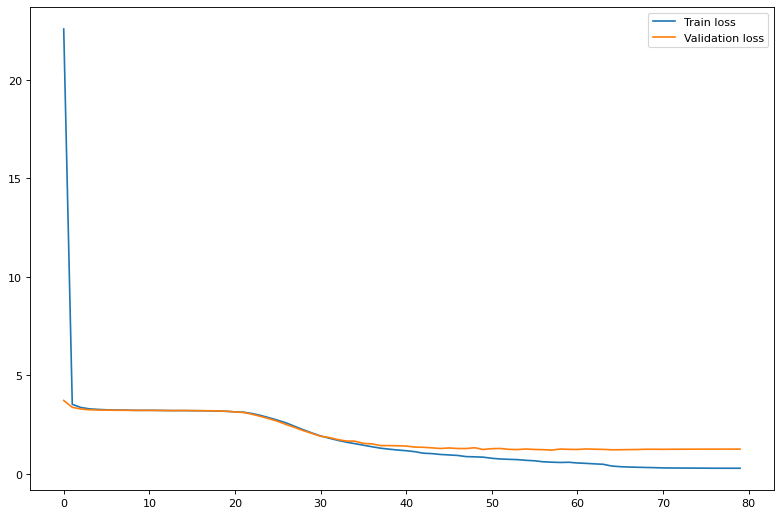

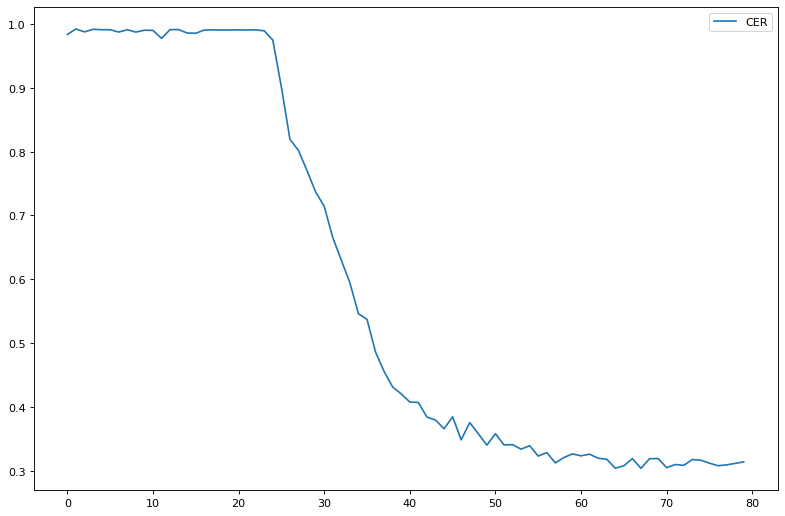

In [63]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')

x = list(range(len(losses_train)))
plt.plot(x,losses_train, label="Train loss")
plt.plot(x,losses_val, label="Validation loss")
plt.legend(loc="upper right")
############################################
plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')

x = list(range(len(cer_val)))
plt.plot(x,cer_val, label="CER")
plt.legend(loc="upper right")


In [64]:
 get_cer(data_loader_test_letters,cpc_model,character_classifier)

N/A% (0 of 175) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (175 of 175) |######################| Elapsed Time: 0:01:32 Time:  0:01:32


Average CER 0.32703193164854716


0.32703193164854716

# Part 3 : Characters recognition without pre-training

Let's estimate the impact of the pre-training by estimating the CER of a model trained from scratch on the labelled dataset.

In [ ]:
import torch.nn.functional as F

def train_one_epoch_ctc(cpc_model, 
                        character_classifier, 
                        loss_criterion, 
                        data_loader, 
                        optimizer):
  
  cpc_model.train()
  loss_criterion.train()

  avg_loss = 0
  avg_accuracy = 0
  n_items = 0
  for step, full_data in enumerate(data_loader):

    x, x_len, y, y_len = full_data

    x_batch_len = x.shape[-1]
    x, y = x.to(device), y.to(device)


    bs=x.size(0)
    optimizer.zero_grad()


    context_out, enc_out = cpc_model(x.to(device))

    scores = character_classifier(context_out)
    scores = scores.permute(1,0,2)
    scores = F.log_softmax(scores,2)
    yhat_len = torch.tensor([int(scores.shape[0]*x_len[i]/(x_batch_len)) for i in range(scores.shape[1])]) # this is an approximation, should be good enough

    #print(yhat_len)
    loss = loss_criterion(scores,y.to(device),yhat_len,y_len)

    loss.backward()
    optimizer.step()
    avg_loss+=loss.item()*bs
    n_items+=bs
  avg_loss/=n_items
  return avg_loss

def validation_step(cpc_model, 
                    character_classifier, 
                    loss_criterion, 
                    data_loader):

  cpc_model.eval()
  character_classifier.eval()
  avg_loss = 0
  avg_accuracy = 0
  n_items = 0
  with torch.no_grad():
    for step, full_data in enumerate(data_loader):

      x, x_len, y, y_len = full_data

      x_batch_len = x.shape[-1]
      x, y = x.to(device), y.to(device)

      bs=x.size(0)
      context_out, enc_out = cpc_model(x.to(device))
    
      scores = character_classifier(context_out)
      scores = scores.permute(1,0,2)
      scores = F.log_softmax(scores,2)
      yhat_len = torch.tensor([int(scores.shape[0]*x_len[i]/x_batch_len) for i in range(scores.shape[1])]) # this is an approximation, should be good enough
      loss = loss_criterion(scores,y.to(device),yhat_len,y_len)
      avg_loss+=loss.item()*bs
      n_items+=bs
  avg_loss/=n_items

  return avg_loss

def run_ctc(cpc_model, 
            character_classifier, 
            loss_criterion, 
            data_loader_train, 
            data_loader_val, 
            optimizer,
            lr_sch,
            n_epoch):
  losses_train = []
  losses_val = []
  cer_val = []
  best_cer = float("inf")
  for epoch in range(n_epoch):

    print(f"Running epoch {epoch + 1} / {n_epoch}")
    loss_train = train_one_epoch_ctc(cpc_model, character_classifier, loss_criterion, data_loader_train, optimizer)
    losses_train.append(loss_train)
    print("-------------------")
    print(f"Training dataset :")
    print(f"Average loss : {loss_train}.")

    print("-------------------")
    print("Validation dataset")
    loss_val = validation_step(cpc_model, character_classifier, loss_criterion, data_loader_val)
    losses_val.append(loss_val)
    lr_sch.step(loss_val)
    cer = get_cer(data_loader_val_letters,cpc_model,character_classifier)
    cer_val.append(cer)

    if cer<best_cer:
      best_cer=cer
      save_checkpoint(cpc_model,character_classifier)

    print(f"Average loss : {loss_val}")
    print("-------------------")
    print()
    if optimizer.param_groups[0]['lr']<1e-7:
      print("Learning rate reached critical point, Aborting")
      break
  print("loading best model with CER ",best_cer)
  load_checkpoint(cpc_model,character_classifier)
  return losses_train,losses_val, cer_val



In [ ]:
import progressbar
from multiprocessing import Pool


def get_cer(test_dataloader,
            cpc_model,
            character_classifier):

  downsampling_factor = 1
  cpc_model.eval()
  character_classifier.eval()

  avgCER = 0
  nItems = 0

  print("Starting the CER computation through beam search")
  bar = progressbar.ProgressBar(maxval=len(test_dataloader))
  bar.start()

  for index, data in enumerate(test_dataloader):

    bar.update(index)
    with torch.no_grad():
        seq, sizeSeq, phone, sizePhone = prepare_data(data)
        x_batch_len = seq.shape[-1]
        c_feature, _= cpc_model(seq.to(device))
        bs = c_feature.size(0)
        sizeSeq = sizeSeq / downsampling_factor
        predictions = torch.nn.functional.softmax(
            character_classifier(c_feature), dim=2
            ).cpu()
        phone = phone.cpu()
        sizeSeq = sizeSeq.cpu()
        sizePhone = sizePhone.cpu()
        # print("predictions",predictions.argmax(2)[0])
        # print(phone[0])
        
        seq_len = torch.tensor([int(predictions.shape[1]*sizeSeq[i]/(x_batch_len)) for i in range(predictions.shape[0])]) # this is an approximation, should be good enough
        #print(seq_len)
        decoder = CTCBeamDecoder(chars, log_probs_input=False,blank_id=0,beam_width=40,cutoff_top_n=40,model_path="/content/wiki_00.lm.arpa")
        output, scores, timesteps, out_seq_len = decoder.decode(predictions, seq_lens=seq_len)
        
        output=output[torch.arange(bs),scores.argmax(1),:]
        out_seq_len= out_seq_len[torch.arange(bs),scores.argmax(1)]
        data_cer = []
        for b in range(bs):
          #print(sizePhone[b],out_seq_len[b])
          data_cer.append((phone[b][:sizePhone[b].item()],output[b][:out_seq_len[b].item()]))
          
        #data_cer = [(predictions[b].argmax(1),  phone[b]) for b in range(bs)]
        # data_cer = [(predictions[b], sizeSeq[b], phone[b], sizePhone[b],
        #               "criterion.module.BLANK_LABEL") for b in range(bs)]
        with Pool(bs) as p:
            poolData = p.starmap(get_CER_sequence, data_cer)
        avgCER += sum([x for x in poolData])
        nItems += len(poolData)

  bar.finish()

  avgCER /= nItems

  print(f"Average CER {avgCER}")
  return avgCER


## Exercice 1: training from scratch on the labelled dataset

What kind of performance will you get if you try to launch the fine-tuning without pre-training ? Check out the PER and the CER of ```cpc_non_pre_trained``` below.

In [ ]:
torch.manual_seed(0)
encoder =  CPCEncoder(DIM_ENCODER).to(device)
context = CPCAR(DIM_ENCODER, DIM_CONTEXT, KEEP_HIDDEN_VECTOR, N_LEVELS_CONTEXT, mode=CONTEXT_RNN).to(device)
cpc_non_pre_trained = CPCModel(encoder, context).to(device)

In [ ]:
torch.manual_seed(0)

character_classifier = CharacterClassifier(DIM_CONTEXT, N_LETTERS).to(device)
parameters = list(character_classifier.parameters()) + list(cpc_non_pre_trained.parameters())
LEARNING_RATE = 2e-4
optimizer = torch.optim.Adam(parameters, lr=LEARNING_RATE)
lr_sch = ReduceLROnPlateau(optimizer,factor=0.2,patience=5,verbose=True)


In [ ]:
loss_ctc = torch.nn.CTCLoss()

In [ ]:
losses_train, losses_val, cer_val = run_ctc(cpc_non_pre_trained,character_classifier,loss_ctc,data_loader_train_letters,data_loader_val_letters,optimizer,lr_sch,n_epoch=80)

Running epoch 1 / 80
-------------------
Training dataset :
Average loss : 4.404074208427022.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:17 Time:  0:00:17


Average PER 0.9982150846476887
Average loss : 3.093962085490324
-------------------

Running epoch 2 / 80
-------------------
Training dataset :
Average loss : 3.087206333951489.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:17 Time:  0:00:17


Average PER 0.9984565439737119
Average loss : 3.086947523817724
-------------------

Running epoch 3 / 80
-------------------
Training dataset :
Average loss : 3.082631982919824.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:17 Time:  0:00:17


Average PER 0.9987556402543825
Average loss : 3.077086507057657
-------------------

Running epoch 4 / 80
-------------------
Training dataset :
Average loss : 3.0804045958676713.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:17 Time:  0:00:17


Average PER 0.9966207089019681
Average loss : 3.088796566943733
-------------------

Running epoch 5 / 80
-------------------
Training dataset :
Average loss : 3.0801538468620553.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:17 Time:  0:00:17


Average PER 0.9777779102486499
Average loss : 3.0713859480254504
-------------------

Running epoch 6 / 80
-------------------
Training dataset :
Average loss : 3.078028620047727.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:17 Time:  0:00:17


Average PER 0.9922828569607275
Average loss : 3.0682941602200877
-------------------

Running epoch 7 / 80
-------------------
Training dataset :
Average loss : 3.0763775010145347.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:17 Time:  0:00:17


Average PER 0.9788174109342818
Average loss : 3.0710537725565383
-------------------

Running epoch 8 / 80
-------------------
Training dataset :
Average loss : 3.0765622183870116.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:17 Time:  0:00:17


Average PER 0.9800597309597725
Average loss : 3.071622595495107
-------------------

Running epoch 9 / 80
-------------------
Training dataset :
Average loss : 3.0748904515768736.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:17 Time:  0:00:17


Average PER 0.9774777902006306
Average loss : 3.070797633151619
-------------------

Running epoch 10 / 80
-------------------
Training dataset :
Average loss : 3.0749020606810205.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:17 Time:  0:00:17


Average PER 0.9779268014666391
Average loss : 3.0685266767229353
-------------------

Running epoch 11 / 80
-------------------
Training dataset :
Average loss : 3.074733717144294.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:17 Time:  0:00:17


Average PER 0.9638681644695457
Average loss : 3.069655009678432
-------------------

Running epoch 12 / 80
-------------------
Training dataset :
Average loss : 3.0740771178374158.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Epoch    12: reducing learning rate of group 0 to 4.0000e-05.
Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:17 Time:  0:00:17


Average PER 0.9777779102486499
Average loss : 3.068122674007805
-------------------

Running epoch 13 / 80
-------------------
Training dataset :
Average loss : 3.070271734669615.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:17 Time:  0:00:17


Average PER 0.9765538177653549
Average loss : 3.0657791020918865
-------------------

Running epoch 14 / 80
-------------------
Training dataset :
Average loss : 3.0691272108306107.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:17 Time:  0:00:17


Average PER 0.9777676321648135
Average loss : 3.0657911738570855
-------------------

Running epoch 15 / 80
-------------------
Training dataset :
Average loss : 3.068876929562207.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:17 Time:  0:00:17


Average PER 0.976653408442712
Average loss : 3.066075563430786
-------------------

Running epoch 16 / 80
-------------------
Training dataset :
Average loss : 3.0693972116814923.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:17 Time:  0:00:17


Average PER 0.9769057208770807
Average loss : 3.0668799682539336
-------------------

Running epoch 17 / 80
-------------------
Training dataset :
Average loss : 3.068482858230746.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:17 Time:  0:00:17


Average PER 0.9823387892594558
Average loss : 3.06682867419963
-------------------

Running epoch 18 / 80
-------------------
Training dataset :
Average loss : 3.0689936776197593.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:17 Time:  0:00:17


Average PER 0.9821990073192826
Average loss : 3.0657505161908207
-------------------

Running epoch 19 / 80
-------------------
Training dataset :
Average loss : 3.068692815212803.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:17 Time:  0:00:17


Average PER 0.9897754930677048
Average loss : 3.0654317262221356
-------------------

Running epoch 20 / 80
-------------------
Training dataset :
Average loss : 3.068614817757643.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:17 Time:  0:00:17


Average PER 0.9751236367544506
Average loss : 3.0657689425410055
-------------------

Running epoch 21 / 80
-------------------
Training dataset :
Average loss : 3.0680479451293556.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:17 Time:  0:00:17


Average PER 0.9880083641297102
Average loss : 3.0666614162678623
-------------------

Running epoch 22 / 80
-------------------
Training dataset :
Average loss : 3.0682797977942546.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:17 Time:  0:00:17


Average PER 0.9897652149838686
Average loss : 3.067145668730444
-------------------

Running epoch 23 / 80
-------------------
Training dataset :
Average loss : 3.068328156726051.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:17 Time:  0:00:17


Average PER 0.977272365405858
Average loss : 3.0669882784084397
-------------------

Running epoch 24 / 80
-------------------
Training dataset :
Average loss : 3.068202987578686.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:17 Time:  0:00:17


Average PER 0.9750529300634245
Average loss : 3.0665046779476866
-------------------

Running epoch 25 / 80
-------------------
Training dataset :
Average loss : 3.0682208453122595.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Epoch    25: reducing learning rate of group 0 to 8.0000e-06.
Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:17 Time:  0:00:17


Average PER 0.9785072892848254
Average loss : 3.0665972476102867
-------------------

Running epoch 26 / 80
-------------------
Training dataset :
Average loss : 3.066971646010421.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:17 Time:  0:00:17


Average PER 0.978631729304736
Average loss : 3.0652760632184086
-------------------

Running epoch 27 / 80
-------------------
Training dataset :
Average loss : 3.0667915890235027.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:17 Time:  0:00:17


Average PER 0.978631729304736
Average loss : 3.0652575152260915
-------------------

Running epoch 28 / 80
-------------------
Training dataset :
Average loss : 3.0667422127177697.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:17 Time:  0:00:17


Average PER 0.9654850110290971
Average loss : 3.065753289631435
-------------------

Running epoch 29 / 80
-------------------
Training dataset :
Average loss : 3.0666920877898316.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:17 Time:  0:00:17


Average PER 0.965645349136943
Average loss : 3.0653879642486572
-------------------

Running epoch 30 / 80
-------------------
Training dataset :
Average loss : 3.066664957818184.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:17 Time:  0:00:17


Average PER 0.9756766906132259
Average loss : 3.06523119673437
-------------------

Running epoch 31 / 80
-------------------
Training dataset :
Average loss : 3.066651133180575.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Epoch    31: reducing learning rate of group 0 to 1.6000e-06.
Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:17 Time:  0:00:17


Average PER 0.9752521305452962
Average loss : 3.065220448435569
-------------------

Running epoch 32 / 80
-------------------
Training dataset :
Average loss : 3.0662821467596157.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:17 Time:  0:00:17


Average PER 0.9752521305452962
Average loss : 3.0653343589938418
-------------------

Running epoch 33 / 80
-------------------
Training dataset :
Average loss : 3.0662613084904717.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:17 Time:  0:00:17


Average PER 0.9752521305452962
Average loss : 3.065361431666783
-------------------

Running epoch 34 / 80
-------------------
Training dataset :
Average loss : 3.0662558175831958.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:17 Time:  0:00:17


Average PER 0.9752521305452962
Average loss : 3.065369985541519
-------------------

Running epoch 35 / 80
-------------------
Training dataset :
Average loss : 3.06627306501374.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:17 Time:  0:00:17


Average PER 0.9756126792005052
Average loss : 3.0653493161104164
-------------------

Running epoch 36 / 80
-------------------
Training dataset :
Average loss : 3.0662491503562634.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:17 Time:  0:00:17


Average PER 0.975861559240326
Average loss : 3.065343306989086
-------------------

Running epoch 37 / 80
-------------------
Training dataset :
Average loss : 3.066238223748049.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Epoch    37: reducing learning rate of group 0 to 3.2000e-07.
Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:17 Time:  0:00:17


Average PER 0.9759306344894734
Average loss : 3.0654001284618766
-------------------

Running epoch 38 / 80
-------------------
Training dataset :
Average loss : 3.0661612139403367.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:17 Time:  0:00:17


Average PER 0.9759306344894734
Average loss : 3.0653869132606353
-------------------

Running epoch 39 / 80
-------------------
Training dataset :
Average loss : 3.0661612588334024.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:17 Time:  0:00:17


Average PER 0.9759306344894734
Average loss : 3.0654056510146783
-------------------

Running epoch 40 / 80
-------------------
Training dataset :
Average loss : 3.0661573598099725.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:17 Time:  0:00:17


Average PER 0.975806194469563
Average loss : 3.0653930537554683
-------------------

Running epoch 41 / 80
-------------------
Training dataset :
Average loss : 3.0661543489412497.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:17 Time:  0:00:17


Average PER 0.975806194469563
Average loss : 3.0653772354125977
-------------------

Running epoch 42 / 80
-------------------
Training dataset :
Average loss : 3.0661500501268693.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:17 Time:  0:00:17


Average PER 0.9759681640192875
Average loss : 3.0653755762139143
-------------------

Running epoch 43 / 80
-------------------
Training dataset :
Average loss : 3.0661530913287445.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Epoch    43: reducing learning rate of group 0 to 6.4000e-08.
Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:17 Time:  0:00:17


Average PER 0.975806194469563
Average loss : 3.0653690124044615
-------------------

Learning rate reached critical point, Aborting
loading best model with CER  0.9638681644695457


In [ ]:
get_cer(data_loader_test_letters,cpc_non_pre_trained,character_classifier)

NameError: ignored

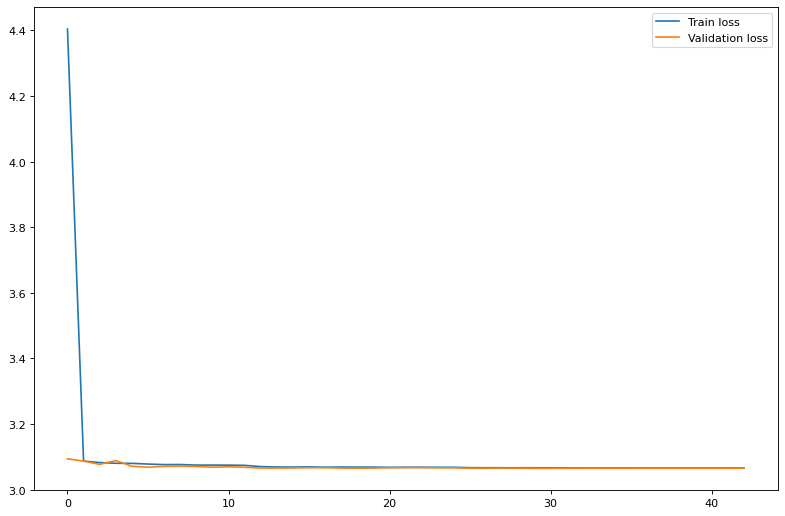

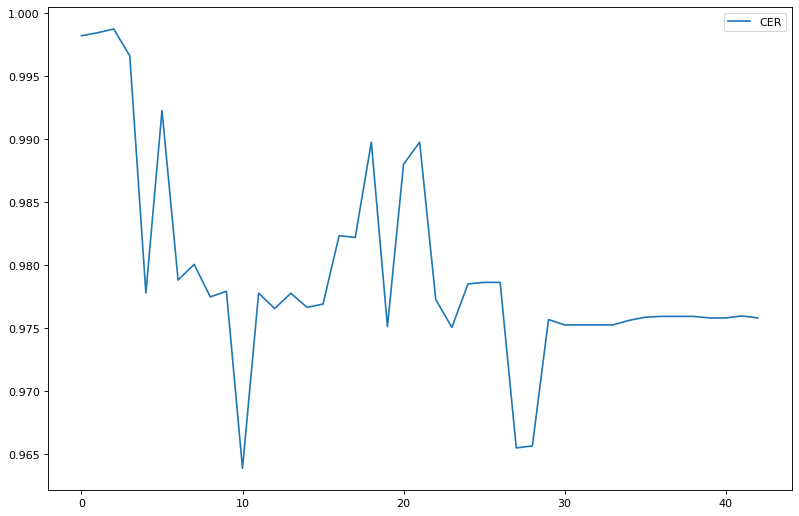

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')

x = list(range(len(losses_train)))
plt.plot(x,losses_train, label="Train loss")
plt.plot(x,losses_val, label="Validation loss")
plt.legend(loc="upper right")
############################################
plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')

x = list(range(len(cer_val)))
plt.plot(x,cer_val, label="CER")
plt.legend(loc="upper right")


## Exercice 2: Comparison with hand-crafted ASR features

Now replace train a character classifier on top of MFCC features. What CER do you get ?

See [here](https://pytorch.org/audio/transforms.html#torchaudio.transforms.MFCC) to build MFCC features.

In [ ]:
mfcc_crafter = torchaudio.transforms.MFCC(n_mfcc=80)

In [ ]:
import torch.nn.functional as F

def train_one_epoch_ctc(character_classifier, 
                        loss_criterion, 
                        data_loader, 
                        optimizer):
  
  cpc_model.train()
  loss_criterion.train()

  avg_loss = 0
  avg_accuracy = 0
  n_items = 0
  for step, full_data in enumerate(data_loader):

    x, x_len, y, y_len = full_data

    x_batch_len = x.shape[-1]
    y = y.to(device)


    bs=x.size(0)
    optimizer.zero_grad()


    #context_out, enc_out = cpc_model(x.to(device))
    context_out = mfcc_crafter(x)
    context_out = context_out.to(device)
    context_out = context_out.squeeze(1)
    context_out = context_out.permute(0,2,1)
    #print("context_out.shape",context_out.shape)

    scores = character_classifier(context_out)
    scores = scores.permute(1,0,2)
    scores = F.log_softmax(scores,2)
    yhat_len = torch.tensor([int(scores.shape[0]*x_len[i]/(x_batch_len)) for i in range(scores.shape[1])]) # this is an approximation, should be good enough

    #print(yhat_len)
    loss = loss_criterion(scores,y.to(device),yhat_len,y_len)

    loss.backward()
    optimizer.step()
    avg_loss+=loss.item()*bs
    n_items+=bs
  avg_loss/=n_items
  return avg_loss

def validation_step(character_classifier, 
                    loss_criterion, 
                    data_loader):

  cpc_model.eval()
  character_classifier.eval()
  avg_loss = 0
  avg_accuracy = 0
  n_items = 0
  with torch.no_grad():
    for step, full_data in enumerate(data_loader):

      x, x_len, y, y_len = full_data

      x_batch_len = x.shape[-1]
      y =  y.to(device)

      bs=x.size(0)
      #context_out, enc_out = cpc_model(x.to(device))
      context_out = mfcc_crafter(x)
      #print("context_out.shape",context_out.shape)
      context_out = context_out.to(device)
      context_out = context_out.squeeze(1)
      context_out = context_out.permute(0,2,1)    
      scores = character_classifier(context_out)
      scores = scores.permute(1,0,2)
      scores = F.log_softmax(scores,2)
      yhat_len = torch.tensor([int(scores.shape[0]*x_len[i]/x_batch_len) for i in range(scores.shape[1])]) # this is an approximation, should be good enough
      loss = loss_criterion(scores,y.to(device),yhat_len,y_len)
      avg_loss+=loss.item()*bs
      n_items+=bs
  avg_loss/=n_items

  return avg_loss

def run_ctc(character_classifier, 
            loss_criterion, 
            data_loader_train, 
            data_loader_val, 
            optimizer,
            lr_sch,
            n_epoch):
  losses_train = []
  losses_val = []
  cer_val = []
  best_cer = float("inf")
  for epoch in range(n_epoch):

    print(f"Running epoch {epoch + 1} / {n_epoch}")
    loss_train = train_one_epoch_ctc(character_classifier, loss_criterion, data_loader_train, optimizer)
    losses_train.append(loss_train)
    print("-------------------")
    print(f"Training dataset :")
    print(f"Average loss : {loss_train}.")

    print("-------------------")
    print("Validation dataset")
    loss_val = validation_step(character_classifier, loss_criterion, data_loader_val)
    losses_val.append(loss_val)
    lr_sch.step(loss_val)
    cer = get_cer(data_loader_val_letters,character_classifier)
    cer_val.append(cer)

    if cer<best_cer:
      best_cer=cer
      save_checkpoint(cpc_model,character_classifier)

    print(f"Average loss : {loss_val}")
    print("-------------------")
    print()
    if optimizer.param_groups[0]['lr']<1e-7:
      print("Learning rate reached critical point, Aborting")
      break
  print("loading best model with CER ",best_cer)
  load_checkpoint(cpc_model,character_classifier)
  return losses_train,losses_val, cer_val



In [ ]:
import progressbar
from multiprocessing import Pool


def get_cer(test_dataloader,
            character_classifier):

  downsampling_factor = 1
  cpc_model.eval()
  character_classifier.eval()

  avgCER = 0
  nItems = 0

  print("Starting the CER computation through beam search")
  bar = progressbar.ProgressBar(maxval=len(test_dataloader))
  bar.start()

  for index, data in enumerate(test_dataloader):

    bar.update(index)
    with torch.no_grad():
        seq, sizeSeq, phone, sizePhone = prepare_data(data)
        x_batch_len = seq.shape[-1]
        c_feature = mfcc_crafter(seq.cpu())
        c_feature = c_feature.to(device)
        c_feature = c_feature.squeeze(1)
        c_feature = c_feature.permute(0,2,1)
        bs = c_feature.size(0)
        sizeSeq = sizeSeq / downsampling_factor
        predictions = torch.nn.functional.softmax(
            character_classifier(c_feature), dim=2
            ).cpu()
        phone = phone.cpu()
        sizeSeq = sizeSeq.cpu()
        sizePhone = sizePhone.cpu()
        # print("predictions",predictions.argmax(2)[0])
        # print(phone[0])
        
        seq_len = torch.tensor([int(predictions.shape[1]*sizeSeq[i]/(x_batch_len)) for i in range(predictions.shape[0])]) # this is an approximation, should be good enough
        #print(seq_len)
        decoder = CTCBeamDecoder(chars, log_probs_input=False,blank_id=0,beam_width=40,cutoff_top_n=40,model_path="/content/wiki_00.lm.arpa")
        output, scores, timesteps, out_seq_len = decoder.decode(predictions, seq_lens=seq_len)
        
        output=output[torch.arange(bs),scores.argmax(1),:]
        out_seq_len= out_seq_len[torch.arange(bs),scores.argmax(1)]
        data_cer = []
        for b in range(bs):
          #print(sizePhone[b],out_seq_len[b])
          data_cer.append((phone[b][:sizePhone[b].item()],output[b][:out_seq_len[b].item()]))
          
        #data_cer = [(predictions[b].argmax(1),  phone[b]) for b in range(bs)]
        # data_cer = [(predictions[b], sizeSeq[b], phone[b], sizePhone[b],
        #               "criterion.module.BLANK_LABEL") for b in range(bs)]
        with Pool(bs) as p:
            poolData = p.starmap(get_CER_sequence, data_cer)
        avgCER += sum([x for x in poolData])
        nItems += len(poolData)

  bar.finish()

  avgCER /= nItems

  print(f"Average CER {avgCER}")
  return avgCER


In [ ]:
character_classifier = CharacterClassifier(80, N_LETTERS).to(device)
torch.manual_seed(0)

parameters = character_classifier.parameters()
LEARNING_RATE = 1e-3
optimizer = torch.optim.Adam(parameters, lr=LEARNING_RATE)
lr_sch = ReduceLROnPlateau(optimizer,factor=0.2,patience=5,verbose=True)


In [ ]:
losses_train, losses_val, cer_val = run_ctc(character_classifier,loss_ctc,data_loader_train_letters,data_loader_val_letters,optimizer,lr_sch,n_epoch=80)

Running epoch 1 / 80
-------------------
Training dataset :
Average loss : 14.751724039325277.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:01:13 Time:  0:01:13


Average PER 0.8390506700817387
Average loss : 8.504963767771818
-------------------

Running epoch 2 / 80
-------------------
Training dataset :
Average loss : 6.691724257918108.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:01:11 Time:  0:01:11


Average PER 0.7657650516839577
Average loss : 5.36388450739335
-------------------

Running epoch 3 / 80
-------------------
Training dataset :
Average loss : 4.741111005535562.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:01:07 Time:  0:01:07


Average PER 0.7572868604321599
Average loss : 4.294742540437348
-------------------

Running epoch 4 / 80
-------------------
Training dataset :
Average loss : 4.135660673825796.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:01:26 Time:  0:01:26


Average PER 0.7737702119854668
Average loss : 4.186240342198586
-------------------

Running epoch 5 / 80
-------------------
Training dataset :
Average loss : 3.997281394235354.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:01:24 Time:  0:01:24


Average PER 0.760206625486238
Average loss : 3.980999990385406
-------------------

Running epoch 6 / 80
-------------------
Training dataset :
Average loss : 3.959689742129571.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:01:02 Time:  0:01:02


Average PER 0.781727260379705
Average loss : 3.9187470114960963
-------------------

Running epoch 7 / 80
-------------------
Training dataset :
Average loss : 3.8921875789875293.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:01:04 Time:  0:01:04


Average PER 0.7885607027446948
Average loss : 3.8318573455421294
-------------------

Running epoch 8 / 80
-------------------
Training dataset :
Average loss : 3.8865963648293764.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:01:16 Time:  0:01:16


Average PER 0.8068313852014161
Average loss : 3.9221557354440493
-------------------

Running epoch 9 / 80
-------------------
Training dataset :
Average loss : 3.82839786369382.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:46 Time:  0:00:46


Average PER 0.806888462647973
Average loss : 3.81952225432104
-------------------

Running epoch 10 / 80
-------------------
Training dataset :
Average loss : 3.781411860735362.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:49 Time:  0:00:49


Average PER 0.8375079641546863
Average loss : 3.8398770799442214
-------------------

Running epoch 11 / 80
-------------------
Training dataset :
Average loss : 3.7575083555459368.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:49 Time:  0:00:49


Average PER 0.8324699455640877
Average loss : 3.832656446768313
-------------------

Running epoch 12 / 80
-------------------
Training dataset :
Average loss : 3.7372495745884553.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:55 Time:  0:00:55


Average PER 0.8230530079583347
Average loss : 3.763090659161003
-------------------

Running epoch 13 / 80
-------------------
Training dataset :
Average loss : 3.7382870181522905.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:01:00 Time:  0:01:00


Average PER 0.7499062340377952
Average loss : 3.7659226437004243
-------------------

Running epoch 14 / 80
-------------------
Training dataset :
Average loss : 3.7049291722343773.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:47 Time:  0:00:47


Average PER 0.8352406047948324
Average loss : 3.9405543025659053
-------------------

Running epoch 15 / 80
-------------------
Training dataset :
Average loss : 3.687989575262288.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:52 Time:  0:00:52


Average PER 0.8424113903036513
Average loss : 3.8485115936824252
-------------------

Running epoch 16 / 80
-------------------
Training dataset :
Average loss : 3.7182703746184136.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:53 Time:  0:00:53


Average PER 0.8332103220821574
Average loss : 3.801217098625339
-------------------

Running epoch 17 / 80
-------------------
Training dataset :
Average loss : 3.7117748272631306.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:51 Time:  0:00:51


Average PER 0.7944808493934123
Average loss : 3.7387642714442038
-------------------

Running epoch 18 / 80
-------------------
Training dataset :
Average loss : 3.696977315058235.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:56 Time:  0:00:56


Average PER 0.8048009755913269
Average loss : 3.8065284855511723
-------------------

Running epoch 19 / 80
-------------------
Training dataset :
Average loss : 3.728127849617684.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:51 Time:  0:00:51


Average PER 0.8223054623111992
Average loss : 3.7243351644399216
-------------------

Running epoch 20 / 80
-------------------
Training dataset :
Average loss : 3.702465736229001.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:51 Time:  0:00:51


Average PER 0.8168843209097959
Average loss : 3.7703750814710344
-------------------

Running epoch 21 / 80
-------------------
Training dataset :
Average loss : 3.708560973936668.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:44 Time:  0:00:44


Average PER 0.841097084811886
Average loss : 3.895431659659561
-------------------

Running epoch 22 / 80
-------------------
Training dataset :
Average loss : 3.70275513452428.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:45 Time:  0:00:45


Average PER 0.8329181472817969
Average loss : 3.8711295857721444
-------------------

Running epoch 23 / 80
-------------------
Training dataset :
Average loss : 3.674356526090899.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:51 Time:  0:00:51


Average PER 0.8235607390324293
Average loss : 3.749088209502551
-------------------

Running epoch 24 / 80
-------------------
Training dataset :
Average loss : 3.6525592676555836.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:46 Time:  0:00:46


Average PER 0.8384732583733003
Average loss : 3.863309081719846
-------------------

Running epoch 25 / 80
-------------------
Training dataset :
Average loss : 3.669807880586037.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Epoch    25: reducing learning rate of group 0 to 2.0000e-04.
Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:48 Time:  0:00:48


Average PER 0.8149168383411293
Average loss : 3.73426907889697
-------------------

Running epoch 26 / 80
-------------------
Training dataset :
Average loss : 3.561784005953762.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:48 Time:  0:00:48


Average PER 0.8106630073143422
Average loss : 3.695334264210292
-------------------

Running epoch 27 / 80
-------------------
Training dataset :
Average loss : 3.5621941447561327.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:51 Time:  0:00:51


Average PER 0.7812837024480325
Average loss : 3.695034815340626
-------------------

Running epoch 28 / 80
-------------------
Training dataset :
Average loss : 3.552366776017439.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:48 Time:  0:00:48


Average PER 0.8131340944103168
Average loss : 3.6987548701617183
-------------------

Running epoch 29 / 80
-------------------
Training dataset :
Average loss : 3.558631740453589.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:48 Time:  0:00:48


Average PER 0.8079171274339355
Average loss : 3.6774789605821883
-------------------

Running epoch 30 / 80
-------------------
Training dataset :
Average loss : 3.54898564688122.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:49 Time:  0:00:49


Average PER 0.781185907773097
Average loss : 3.7003912098553715
-------------------

Running epoch 31 / 80
-------------------
Training dataset :
Average loss : 3.551024154245702.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:47 Time:  0:00:47


Average PER 0.8227109652205562
Average loss : 3.6826385867838956
-------------------

Running epoch 32 / 80
-------------------
Training dataset :
Average loss : 3.5569422008427045.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:47 Time:  0:00:47


Average PER 0.81455560369967
Average loss : 3.6778607027871266
-------------------

Running epoch 33 / 80
-------------------
Training dataset :
Average loss : 3.55246086703002.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:46 Time:  0:00:46


Average PER 0.8068906641772273
Average loss : 3.677312335189508
-------------------

Running epoch 34 / 80
-------------------
Training dataset :
Average loss : 3.550132932857096.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:47 Time:  0:00:47


Average PER 0.8289309140491516
Average loss : 3.710183673975419
-------------------

Running epoch 35 / 80
-------------------
Training dataset :
Average loss : 3.55128842819738.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Epoch    35: reducing learning rate of group 0 to 4.0000e-05.
Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:48 Time:  0:00:48


Average PER 0.8038470715841144
Average loss : 3.678235808197333
-------------------

Running epoch 36 / 80
-------------------
Training dataset :
Average loss : 3.528353746307412.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:48 Time:  0:00:48


Average PER 0.8098258601200616
Average loss : 3.6717075620378767
-------------------

Running epoch 37 / 80
-------------------
Training dataset :
Average loss : 3.523666632994441.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:47 Time:  0:00:47


Average PER 0.8164703837199323
Average loss : 3.6787517995250467
-------------------

Running epoch 38 / 80
-------------------
Training dataset :
Average loss : 3.51395558097587.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:47 Time:  0:00:47


Average PER 0.813343358807571
Average loss : 3.672595535005842
-------------------

Running epoch 39 / 80
-------------------
Training dataset :
Average loss : 3.5240296729041725.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:48 Time:  0:00:48


Average PER 0.8053368191531358
Average loss : 3.6728606661971734
-------------------

Running epoch 40 / 80
-------------------
Training dataset :
Average loss : 3.5226182967955224.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:48 Time:  0:00:48


Average PER 0.8152489476495431
Average loss : 3.6792584584683787
-------------------

Running epoch 41 / 80
-------------------
Training dataset :
Average loss : 3.52745342921968.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:48 Time:  0:00:48


Average PER 0.8075836483435418
Average loss : 3.6720701139800402
-------------------

Running epoch 42 / 80
-------------------
Training dataset :
Average loss : 3.5225234225809423.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:48 Time:  0:00:48


Average PER 0.8027028748236278
Average loss : 3.670502487494021
-------------------

Running epoch 43 / 80
-------------------
Training dataset :
Average loss : 3.527396695911126.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:47 Time:  0:00:47


Average PER 0.8041581922098027
Average loss : 3.668104721575367
-------------------

Running epoch 44 / 80
-------------------
Training dataset :
Average loss : 3.5247274901120718.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:47 Time:  0:00:47


Average PER 0.8074058934498693
Average loss : 3.6722177340059865
-------------------

Running epoch 45 / 80
-------------------
Training dataset :
Average loss : 3.5242445311170196.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:46 Time:  0:00:46


Average PER 0.8218346320142379
Average loss : 3.677501931482432
-------------------

Running epoch 46 / 80
-------------------
Training dataset :
Average loss : 3.522743852387251.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:46 Time:  0:00:46


Average PER 0.8228273837442107
Average loss : 3.6799447682439066
-------------------

Running epoch 47 / 80
-------------------
Training dataset :
Average loss : 3.533651650406932.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:46 Time:  0:00:46


Average PER 0.8191996409650845
Average loss : 3.67479031426566
-------------------

Running epoch 48 / 80
-------------------
Training dataset :
Average loss : 3.5202110790417698.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:47 Time:  0:00:47


Average PER 0.8200275757147051
Average loss : 3.6725326849489797
-------------------

Running epoch 49 / 80
-------------------
Training dataset :
Average loss : 3.5290003793536857.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Epoch    49: reducing learning rate of group 0 to 8.0000e-06.
Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:46 Time:  0:00:46


Average PER 0.8240965278346147
Average loss : 3.682245434546957
-------------------

Running epoch 50 / 80
-------------------
Training dataset :
Average loss : 3.5180889504556436.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:47 Time:  0:00:47


Average PER 0.8150730991932671
Average loss : 3.6698631461785762
-------------------

Running epoch 51 / 80
-------------------
Training dataset :
Average loss : 3.5226071481486314.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:46 Time:  0:00:46


Average PER 0.8172515622350776
Average loss : 3.6699948408165755
-------------------

Running epoch 52 / 80
-------------------
Training dataset :
Average loss : 3.5248227167978845.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:47 Time:  0:00:47


Average PER 0.8199995969528122
Average loss : 3.6728284261664568
-------------------

Running epoch 53 / 80
-------------------
Training dataset :
Average loss : 3.5147703919398574.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:46 Time:  0:00:46


Average PER 0.8167290024285551
Average loss : 3.673365135582126
-------------------

Running epoch 54 / 80
-------------------
Training dataset :
Average loss : 3.5166070879870697.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:47 Time:  0:00:47


Average PER 0.8172477001413715
Average loss : 3.6715814824006996
-------------------

Running epoch 55 / 80
-------------------
Training dataset :
Average loss : 3.516848569607917.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Epoch    55: reducing learning rate of group 0 to 1.6000e-06.
Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:47 Time:  0:00:47


Average PER 0.8202819299172844
Average loss : 3.6709189998860263
-------------------

Running epoch 56 / 80
-------------------
Training dataset :
Average loss : 3.5167478447348715.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:47 Time:  0:00:47


Average PER 0.8153566063351864
Average loss : 3.6700233002098237
-------------------

Running epoch 57 / 80
-------------------
Training dataset :
Average loss : 3.5152713318210824.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:47 Time:  0:00:47


Average PER 0.8157369201410611
Average loss : 3.669901434256106
-------------------

Running epoch 58 / 80
-------------------
Training dataset :
Average loss : 3.5125519574143502.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:47 Time:  0:00:47


Average PER 0.8169097610947839
Average loss : 3.6698907102857317
-------------------

Running epoch 59 / 80
-------------------
Training dataset :
Average loss : 3.514064581946259.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:48 Time:  0:00:48


Average PER 0.8161386690646489
Average loss : 3.6694022246769498
-------------------

Running epoch 60 / 80
-------------------
Training dataset :
Average loss : 3.5178153696860974.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:47 Time:  0:00:47


Average PER 0.8153956643013018
Average loss : 3.670129357552042
-------------------

Running epoch 61 / 80
-------------------
Training dataset :
Average loss : 3.515280526406286.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Epoch    61: reducing learning rate of group 0 to 3.2000e-07.
Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:47 Time:  0:00:47


Average PER 0.8162379270656449
Average loss : 3.669950227348172
-------------------

Running epoch 62 / 80
-------------------
Training dataset :
Average loss : 3.5071883146999445.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:47 Time:  0:00:47


Average PER 0.8152201952073134
Average loss : 3.6699189117976596
-------------------

Running epoch 63 / 80
-------------------
Training dataset :
Average loss : 3.5163517586754174.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:47 Time:  0:00:47


Average PER 0.8153826285097708
Average loss : 3.6698810178406385
-------------------

Running epoch 64 / 80
-------------------
Training dataset :
Average loss : 3.5177293958251408.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:47 Time:  0:00:47


Average PER 0.8159084091210019
Average loss : 3.66978044412574
-------------------

Running epoch 65 / 80
-------------------
Training dataset :
Average loss : 3.5188421839066133.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:47 Time:  0:00:47


Average PER 0.816439016737605
Average loss : 3.669826702195771
-------------------

Running epoch 66 / 80
-------------------
Training dataset :
Average loss : 3.513146505404368.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:47 Time:  0:00:47


Average PER 0.8150009423902675
Average loss : 3.6697846480778287
-------------------

Running epoch 67 / 80
-------------------
Training dataset :
Average loss : 3.5138028474861125.
-------------------
Validation dataset


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Epoch    67: reducing learning rate of group 0 to 6.4000e-08.
Starting the PER computation through beam search


100% (49 of 49) |########################| Elapsed Time: 0:00:47 Time:  0:00:47


Average PER 0.815812096619695
Average loss : 3.6697291987282887
-------------------

Learning rate reached critical point, Aborting
loading best model with CER  0.7499062340377952


In [ ]:
get_cer(data_loader_test_letters,character_classifier)

N/A% (0 of 246) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (246 of 246) |######################| Elapsed Time: 0:04:20 Time:  0:04:20


Average PER 0.7487240674442


0.7487240674442

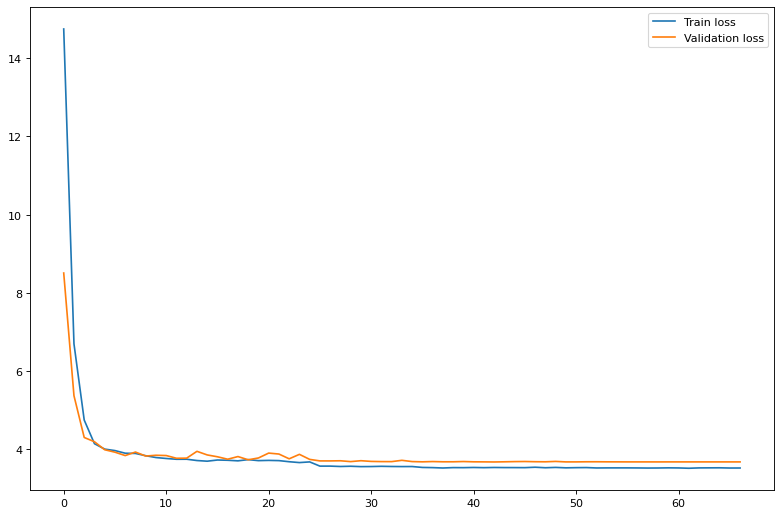

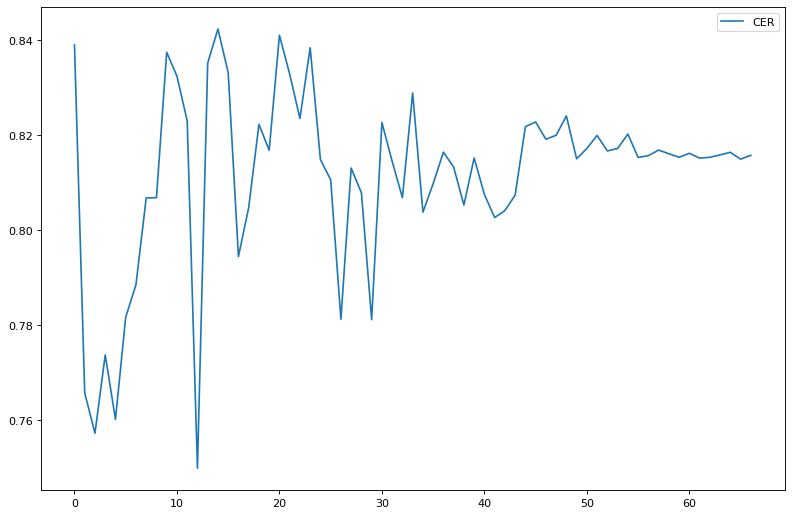

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')

x = list(range(len(losses_train)))
plt.plot(x,losses_train, label="Train loss")
plt.plot(x,losses_val, label="Validation loss")
plt.legend(loc="upper right")
############################################
plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')

x = list(range(len(cer_val)))
plt.plot(x,cer_val, label="CER")
plt.legend(loc="upper right")

# New Section